In [1]:
import pandas
from scipy.io import arff
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import time
from dl85 import DL85Predictor
from dl85 import DL85Classifier
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import numpy as np
import utils
import graphviz
import multiprocessing
from concurrent.futures import ThreadPoolExecutor
import ast

In [2]:
pd.set_option('max_columns', None)
FILE_NAME = "lawsuit_k_supp2"

# src: https://www.kaggle.com/hjmjerry/gender-discrimination
df = pandas.read_csv("../dataset_perso/Lawsuit.csv")
del df['ID']
df

,Dept,Gender,Clin,Cert,Prate,Exper,Rank,Sal94,Sal95
0,1,1,0,0,7.4,9,3,77836,84612
1,1,1,0,0,6.7,10,2,69994,78497
2,1,1,0,0,8.1,6,1,62872,67756
3,1,1,1,1,5.1,27,3,155196,173220
4,1,1,0,0,7.0,10,3,89268,96099
...,...,...,...,...,...,...,...,...,...
256,6,0,1,1,2.9,8,2,297174,323699
257,6,0,1,1,2.6,9,3,308081,339664
258,6,0,1,1,2.8,8,1,211269,241577
259,6,0,1,1,2.4,2,1,210801,233905


In [3]:
salary_mean = np.mean(np.array(df["Sal94"].tolist(), float))
for i in range(0,len(df)):
    if df.at[i, "Sal94"] >= salary_mean:
        df.at[i, "Salary_mean"] = 1
    else:
        df.at[i, "Salary_mean"] = 0
del df["Sal94"]
del df["Sal95"]
df

,Dept,Gender,Clin,Cert,Prate,Exper,Rank,Salary_mean
0,1,1,0,0,7.4,9,3,0.0
1,1,1,0,0,6.7,10,2,0.0
2,1,1,0,0,8.1,6,1,0.0
3,1,1,1,1,5.1,27,3,1.0
4,1,1,0,0,7.0,10,3,0.0
...,...,...,...,...,...,...,...,...
256,6,0,1,1,2.9,8,2,1.0
257,6,0,1,1,2.6,9,3,1.0
258,6,0,1,1,2.8,8,1,1.0
259,6,0,1,1,2.4,2,1,1.0


In [4]:
col = ['Rank', 'Dept']
df = df.drop(['Prate', 'Exper'], axis=1)
df = pd.get_dummies(df, columns=col)
df


,Gender,Clin,Cert,Salary_mean,Rank_1,Rank_2,Rank_3,Dept_1,Dept_2,Dept_3,Dept_4,Dept_5,Dept_6
0,1,0,0,0.0,0,0,1,1,0,0,0,0,0
1,1,0,0,0.0,0,1,0,1,0,0,0,0,0
2,1,0,0,0.0,1,0,0,1,0,0,0,0,0
3,1,1,1,1.0,0,0,1,1,0,0,0,0,0
4,1,0,0,0.0,0,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,0,1,1,1.0,0,1,0,0,0,0,0,0,1
257,0,1,1,1.0,0,0,1,0,0,0,0,0,1
258,0,1,1,1.0,1,0,0,0,0,0,0,0,1
259,0,1,1,1.0,1,0,0,0,0,0,0,0,1


In [5]:
X = df.loc[:, ~df.columns.isin(['Gender', 'Salary_mean'])]
y = df['Salary_mean']
sensitive = df['Gender']
print(utils.discrimination(y, sensitive))

-0.31205112598904444


In [6]:
for i in range(0,len(df)):
    if df.at[i, "Gender"] == 1:
        df.at[i, "Gender"] = 0
    else:
        df.at[i, "Gender"] = 1

In [7]:
X = df.loc[:, ~df.columns.isin(['Gender', 'Salary_mean'])]
y = df['Salary_mean']
sensitive = df['Gender']
print(utils.discrimination(y, sensitive))

0.31205112598904444


In [8]:
X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = utils.train_test_split(1, X, y, sensitive)

In [9]:


from tqdm import tqdm
from multiprocessing import Process, Pool
from functools import partial

result = pd.DataFrame(columns=["k", "depth", "random_state", "clf.error_", "clf.accuracy_", "accuracy_pred", "accuracy_test", "sum_misclassified_train", "discrimination_train", "discrimination_train_pred", "discrimination_test", "sum_discrimination_additive_train", "sum_discrimination_additive_train_pred", "sum_discrimination_additive_test_pred", "sum_discrimination_additive_train_abs", "sum_discrimination_additive_train_pred_abs", "sum_discrimination_additive_test_pred_abs", "duration", "min_supp", "clf.tree_"])

def xx(min_supp, random_state, X_train, X_test, y_train, y_test, sensitive_train, sensitive_test, depth, k):

    clf = DL85Classifier(max_depth=depth, error_function=lambda tids: utils.error(list(tids), k, y_train, sensitive_train), min_sup=min_supp, time_limit=600)

    start = time.perf_counter()
    clf.fit(X_train, list(y_train))
    duration = time.perf_counter() - start
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    accuracy_pred = round(accuracy_score(y_train, y_pred_train), 8)
    accuracy_test = round(accuracy_score(y_test, y_pred_test), 8)
    discrimination_train = round(utils.discrimination(y_train, sensitive_train), 8)
    discrimination_train_pred = round(utils.discrimination(y_pred_train, sensitive_train), 8)
    discrimination_test = round(utils.discrimination(y_pred_test, sensitive_test), 8)

    utils.tree_upgrade(clf.tree_, y_train, np.asarray(y_pred_train), sensitive_train)
    sum_discrimination_additive_train_pred = round(utils.sum_elem_tree(ast.literal_eval(str(clf.tree_)), 'discrimination_additive_pred', do_abs=False),8)
    sum_discrimination_additive_train_pred_abs = round(utils.sum_elem_tree(ast.literal_eval(str(clf.tree_)), 'discrimination_additive_pred', do_abs=True),8)

    sum_discrimination_additive_train = round(utils.sum_elem_tree(ast.literal_eval(str(clf.tree_)), 'discrimination_additive_train', do_abs=False),8)
    sum_discrimination_additive_train_abs = round(utils.sum_elem_tree(ast.literal_eval(str(clf.tree_)), 'discrimination_additive_train', do_abs=True),8)
    sum_misclassified_train = round(utils.sum_elem_tree(clf.tree_, 'misclassified'),8)

    discri_test= list()
    utils.get_discri_test(clf.tree_, X_test, y_pred_test, sensitive_test, discri_test, X.columns, path=None)
    sum_discrimination_additive_test_pred = sum(discri_test)
    sum_discrimination_additive_test_pred_abs = 0
    [sum_discrimination_additive_test_pred_abs := sum_discrimination_additive_test_pred_abs + abs(d) for d in discri_test]
    #print(f"### Depth: {depth} state: {random_state} k:{k} ###")

    return [k, depth, random_state, clf.error_, clf.accuracy_, accuracy_pred, accuracy_test, sum_misclassified_train, discrimination_train, discrimination_train_pred, discrimination_test, sum_discrimination_additive_train, sum_discrimination_additive_train_pred, sum_discrimination_additive_test_pred, sum_discrimination_additive_train_abs, sum_discrimination_additive_train_pred_abs, sum_discrimination_additive_test_pred_abs, duration, min_supp, clf.tree_]

pool = Pool()
if True:
    min_supp = 2
    args = []
    for depth in [1, 2, 3, 4, 5, 6, 7]:
        for k in [0, 1, 5, 10, 50, 100, 250, 500, 1000, 5000, 100000]:
            args.append((depth, k))
    for random_state in tqdm(range(1, 101, 2)):
        if random_state in [17, 35, 43, 71, 91]:
                continue
        X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = utils.train_test_split(random_state, X, y, sensitive)

        for res in pool.starmap(partial(xx, min_supp, random_state, X_train, X_test, y_train, y_test, sensitive_train, sensitive_test), args):
            result.loc[len(result.index)] = res

    result = result.sort_values(['k', 'depth', 'min_supp'])
    result.to_csv('save/'+FILE_NAME+'.csv', index=False)

In [10]:
result = pd.read_csv('save/'+FILE_NAME+".csv")
result

,k,depth,random_state,clf.error_,clf.accuracy_,accuracy_pred,accuracy_test,sum_misclassified_train,discrimination_train,discrimination_train_pred,discrimination_test,sum_discrimination_additive_train,sum_discrimination_additive_train_pred,sum_discrimination_additive_test_pred,sum_discrimination_additive_train_abs,sum_discrimination_additive_train_pred_abs,sum_discrimination_additive_test_pred_abs,duration,min_supp,clf.tree_
0,0,1,1,51.000000,0.755981,0.755981,0.730769,51,0.325619,0.156476,0.266667,0.325619,0.156476,0.260606,0.325619,0.156476,0.272727,0.009918,2,"{'feat': 10, 'left': {'value': 1, 'error': 0.0..."
1,0,1,3,48.000000,0.770335,0.770335,0.673077,48,0.304364,0.234535,-0.046083,0.304364,0.234535,0.342550,0.304364,0.234535,0.434716,0.003364,2,"{'feat': 10, 'left': {'value': 1, 'error': 0.0..."
2,0,1,5,49.000000,0.765550,0.765550,0.692308,49,0.324563,0.179566,0.172619,0.324563,0.179566,0.279762,0.324563,0.179566,0.279762,0.005165,2,"{'feat': 10, 'left': {'value': 1, 'error': 0.0..."
3,0,1,7,51.000000,0.755981,0.755981,0.730769,51,0.290782,0.185791,0.137931,0.290782,0.185791,0.386807,0.290782,0.185791,0.386807,0.011934,2,"{'feat': 10, 'left': {'value': 1, 'error': 0.0..."
4,0,1,9,54.000000,0.741627,0.741627,0.788462,54,0.316116,0.144628,0.297386,0.316116,0.144628,0.281046,0.316116,0.144628,0.313725,0.009548,2,"{'feat': 10, 'left': {'value': 1, 'error': 0.0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3460,100000,7,89,9635.744141,-45.104038,0.784689,0.730769,45,0.318990,0.087110,0.125937,0.318990,0.087110,0.290855,0.343087,0.095907,0.464768,2.715636,2,"{'feat': 7, 'left': {'feat': 0, 'left': {'feat..."
3461,100000,7,93,8099.851074,-37.755268,0.799043,0.884615,42,0.298554,0.070248,0.336601,0.298554,0.070248,0.388889,0.298554,0.080579,0.388889,2.748363,2,"{'feat': 0, 'left': {'feat': 5, 'left': {'valu..."
3462,100000,7,95,13012.431641,-61.260437,0.813397,0.807692,39,0.353778,0.112587,0.100478,0.353778,0.112587,0.138756,0.383362,0.129734,0.467305,2.803768,2,"{'feat': 5, 'left': {'feat': 0, 'left': {'valu..."
3463,100000,7,97,13510.681641,-63.644409,0.846890,0.730769,32,0.342636,0.119864,0.038462,0.342636,0.119864,0.192308,0.377132,0.134787,0.423077,2.747611,2,"{'feat': 3, 'left': {'feat': 5, 'left': {'valu..."


accuracy_pred = 0.89952153
accuracy_test = 0.86538462
discrimination_train = 0.32561905
discrimination_train_pred = 0.238


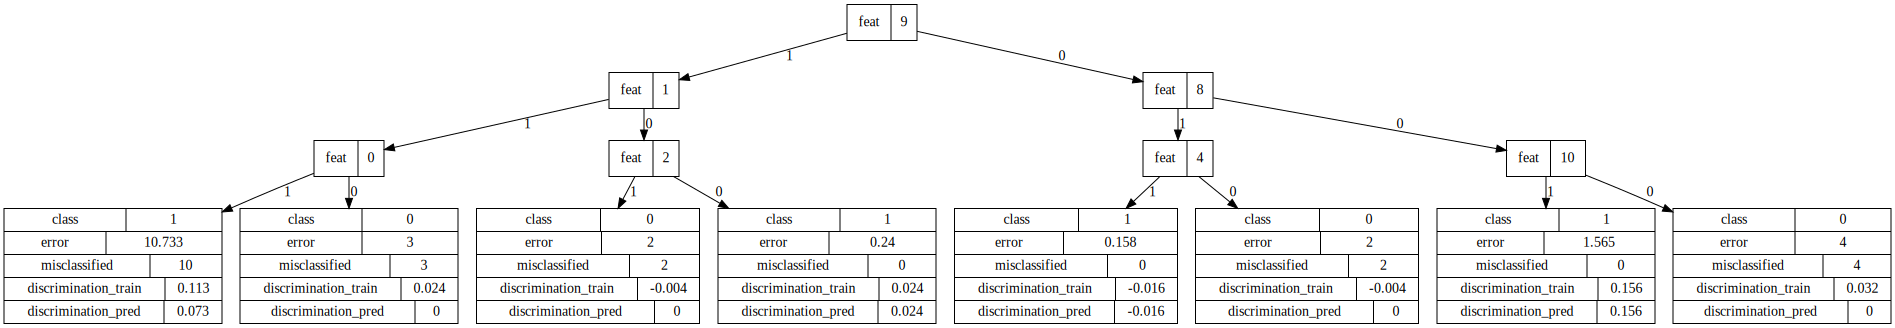

In [11]:
X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = utils.train_test_split(1, X, y, sensitive)

clf = DL85Classifier(max_depth=3, error_function=lambda tids: utils.error(list(tids), 10, y_train, sensitive_train), min_sup=1, time_limit=600)
clf.fit(X_train, list(y_train))
y_pred_train = clf.predict(X_train)

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
print(f'accuracy_pred = {round(accuracy_score(y_train, y_pred_train), 8)}')
print(f'accuracy_test = {round(accuracy_score(y_test, y_pred_test), 8)}')
print(f'discrimination_train = {round(utils.discrimination(y_train, sensitive_train), 8)}')
print(f'discrimination_train_pred = {round(utils.discrimination(y_pred_train, sensitive_train), 8)}')

utils.tree_upgrade(clf.tree_, y_train, np.asarray(y_pred_train), sensitive_train)
dot = utils.export_graphviz(clf)
graph = graphviz.Source(dot, format="png")
graph.render("plots/"+FILE_NAME+"tree")
graphviz.Source(dot)


In [12]:
discri_test= list()
utils.get_discri_test(clf.tree_, X_test, y_test, sensitive_test, discri_test, X.columns, path=None)
sum_discrimination_additive_test_pred = sum(discri_test)
sum_discrimination_additive_test_pred_abs = 0
[sum_discrimination_additive_test_pred_abs := sum_discrimination_additive_test_pred_abs + abs(d) for d in discri_test]
print(sum_discrimination_additive_test_pred)
sum_discrimination_additive_test_pred_abs

0.26060606060606056


0.5393939393939394

In [13]:
discri_test

[-0.09393939393939393,
 -0.045454545454545456,
 0.0,
 0.06666666666666667,
 0.0,
 0.0,
 0.26666666666666666,
 0.06666666666666667]

In [14]:
utils.discrimination(y_train, sensitive_train)

0.32561904761904764

In [15]:
print(utils.sum_elem_tree(clf.tree_, 'discrimination_additive_train'))
print(utils.sum_elem_tree(clf.tree_, 'discrimination_additive_train', do_abs=True))
print(utils.sum_elem_tree(clf.tree_, 'discrimination_additive_pred'))
print(utils.sum_elem_tree(clf.tree_, 'discrimination_additive_pred', do_abs=True))

0.3256190476190476
0.3728571428571429
0.23800000000000002
0.26961904761904765


In [16]:
utils.sum_elem_tree(clf.tree_, 'misclassified')

21

In [17]:
print(utils.discrimination(y_train, sensitive_train))
print(utils.discrimination(y_pred_train, sensitive_train))
print(utils.discrimination(y_test, sensitive_test))
print(utils.discrimination(y_pred_test, sensitive_test))

0.32561904761904764
0.238
0.2606060606060606
0.29393939393939394


In [18]:
clf.tree_

{'feat': 9,
 'left': {'feat': 1,
  'left': {'feat': 0,
   'left': {'value': 1,
    'error': 10.733334,
    'transactions': [128,
     129,
     130,
     131,
     132,
     133,
     135,
     136,
     137,
     139,
     140,
     141,
     143,
     146,
     152,
     153,
     154,
     156,
     157,
     158,
     159,
     160,
     161,
     162,
     165,
     166,
     167,
     168,
     169,
     171,
     174,
     113,
     115,
     117,
     118,
     119,
     120,
     121,
     122,
     123,
     124,
     125,
     126,
     127],
    'proba': [0.22727272727272727, 0.7727272727272727],
    'discrimination_additive_train': 0.11276190476190476,
    'discrimination_additive_pred': 0.07333333333333333,
    'misclassified': 10},
   'right': {'value': 0,
    'error': 3.0,
    'transactions': [134, 173, 175, 144, 145, 114, 176, 116, 148],
    'proba': [0.6666666666666666, 0.3333333333333333],
    'discrimination_additive_train': 0.024,
    'discrimination_additive_pred'

# Graphs

<Figure size 648x432 with 0 Axes>

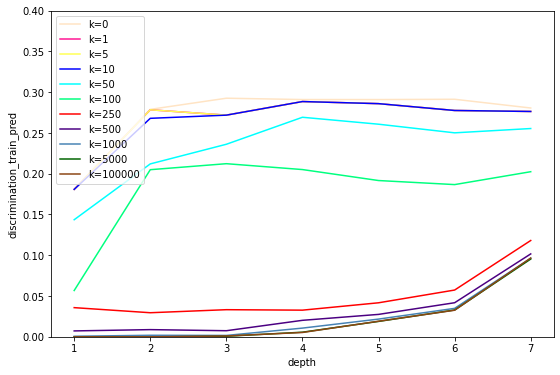

In [19]:
utils.plot_mean("depth", "discrimination_train_pred", result, 0, 0.4)

<Figure size 648x432 with 0 Axes>

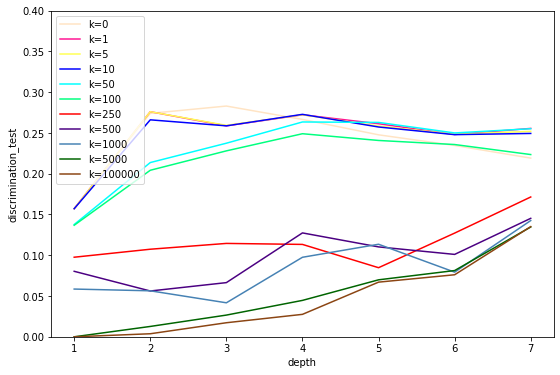

In [20]:
utils.plot_mean("depth", "discrimination_test", result, 0, 0.4)

<Figure size 648x432 with 0 Axes>

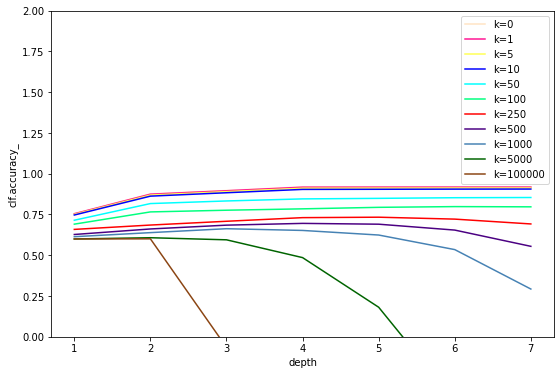

In [21]:
utils.plot_mean("depth", "clf.accuracy_", result, 0, 2)

<Figure size 648x432 with 0 Axes>

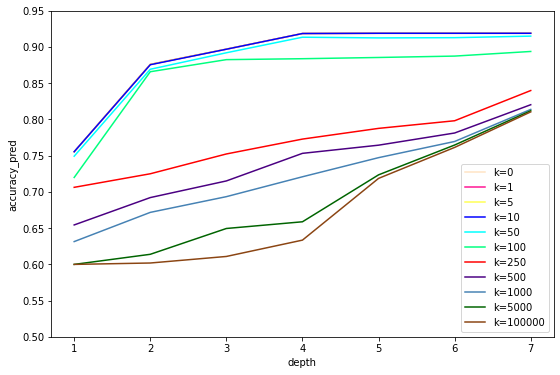

In [22]:
utils.plot_mean("depth", "accuracy_pred", result, 0.5, 0.95)

<Figure size 648x432 with 0 Axes>

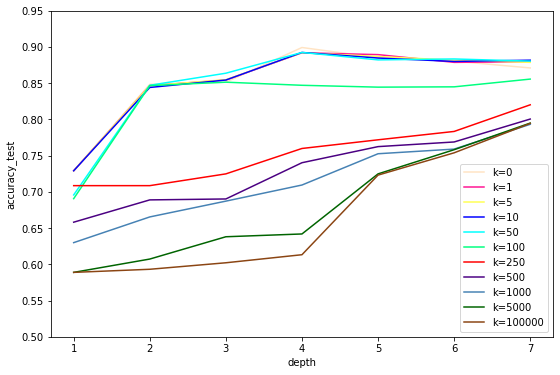

In [23]:
utils.plot_mean("depth", "accuracy_test", result, 0.5, 0.95)

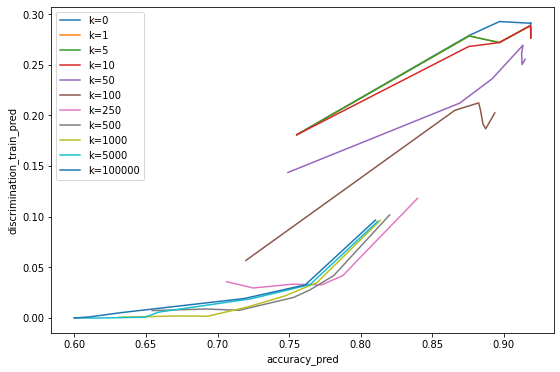

In [24]:
utils.plot2("accuracy_pred", "discrimination_train_pred", result)

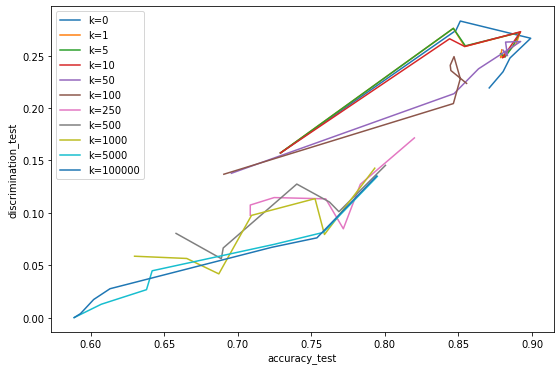

In [25]:
utils.plot2("accuracy_test", "discrimination_test", result)

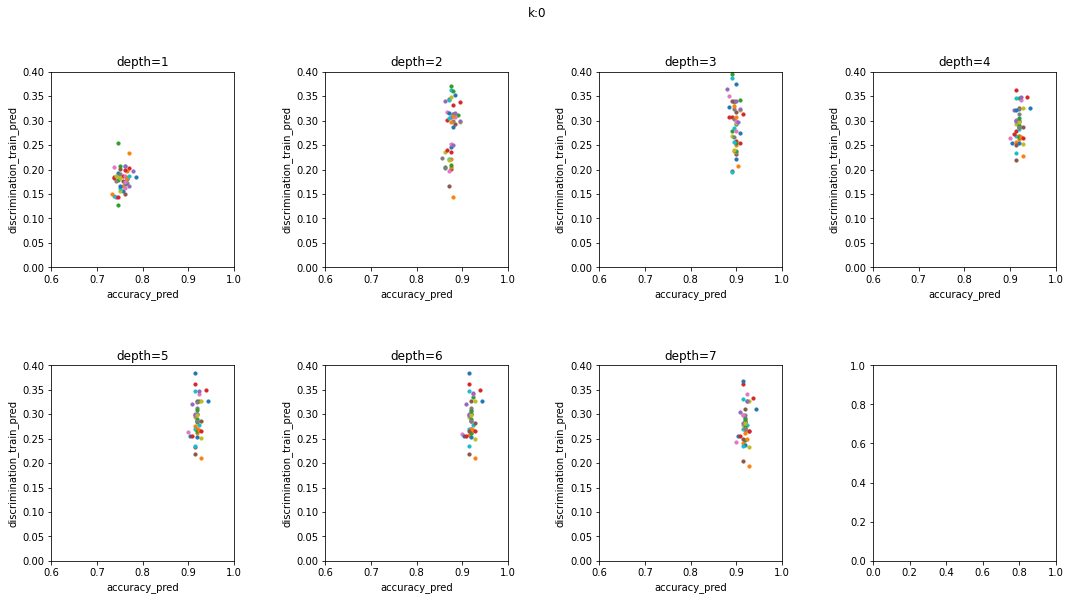

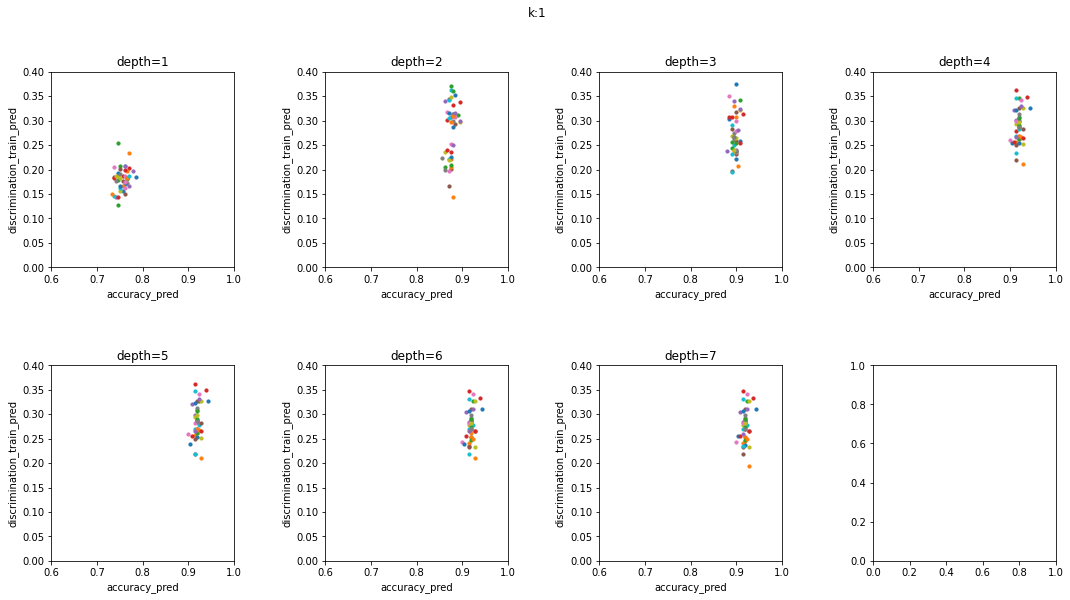

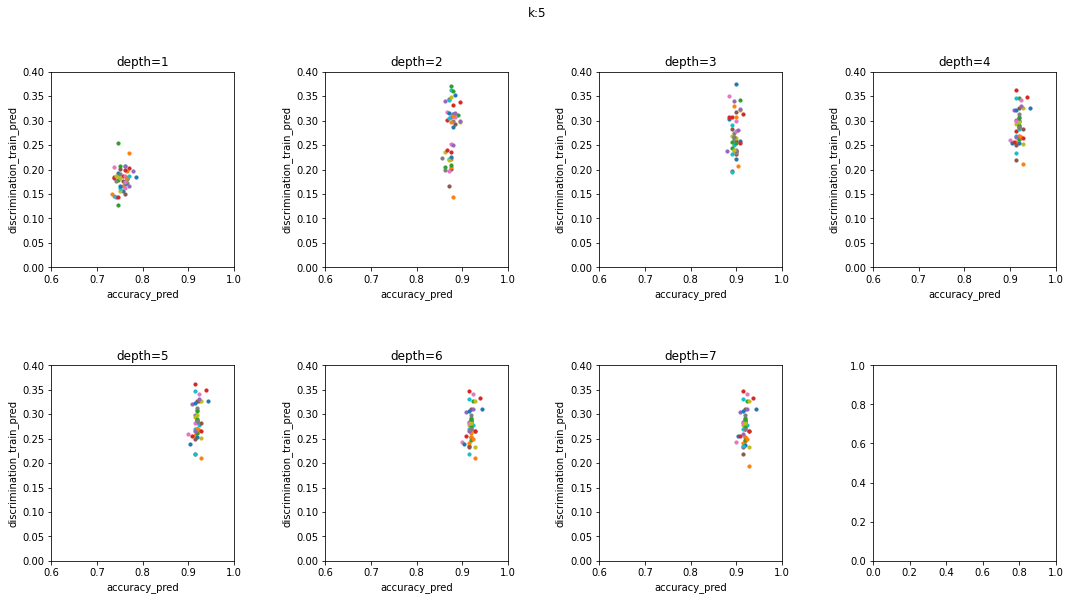

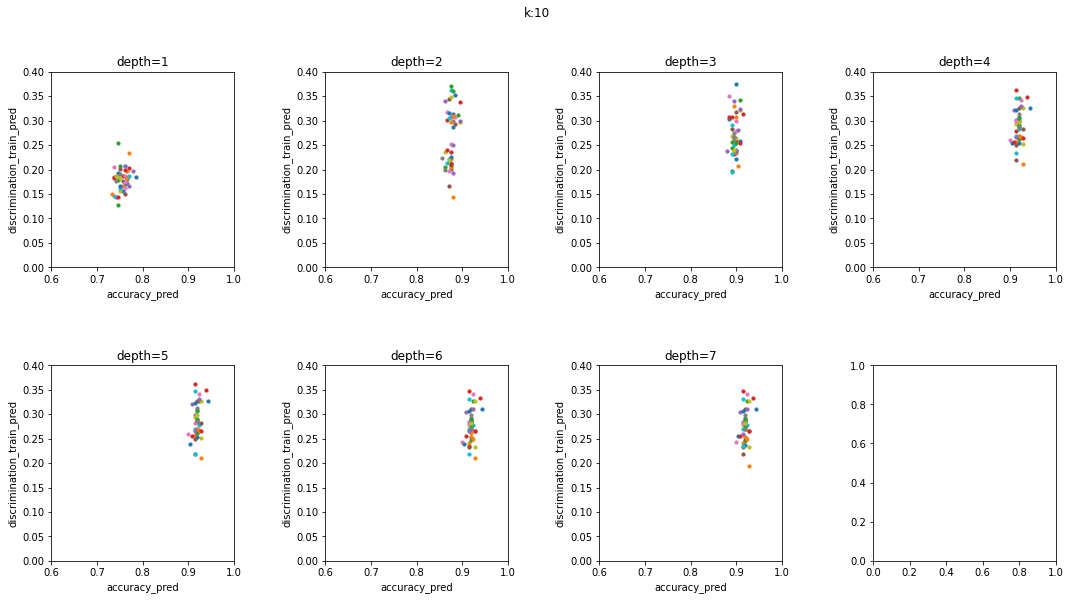

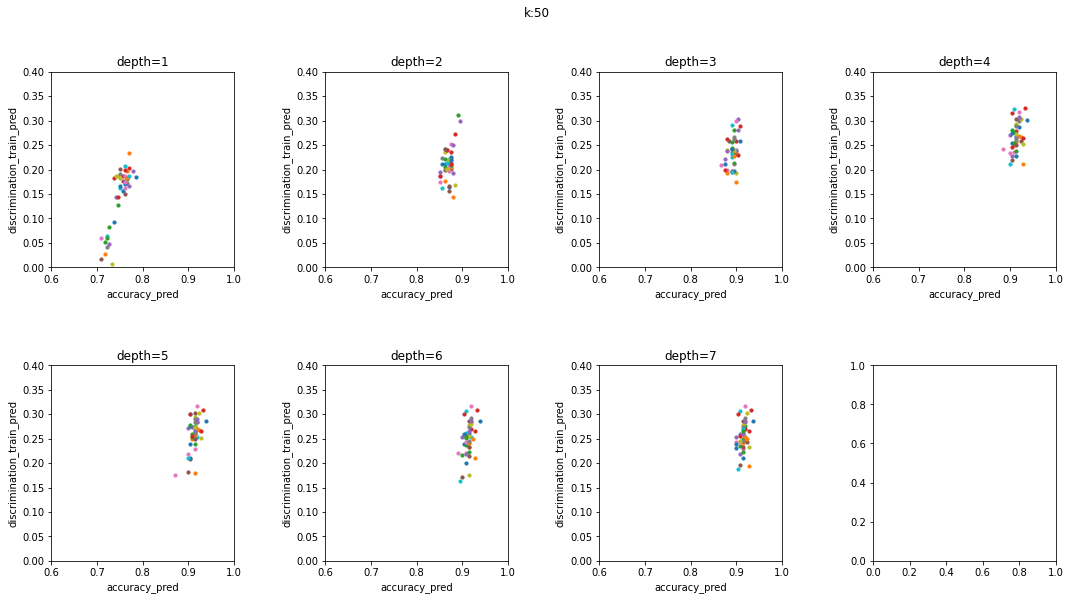

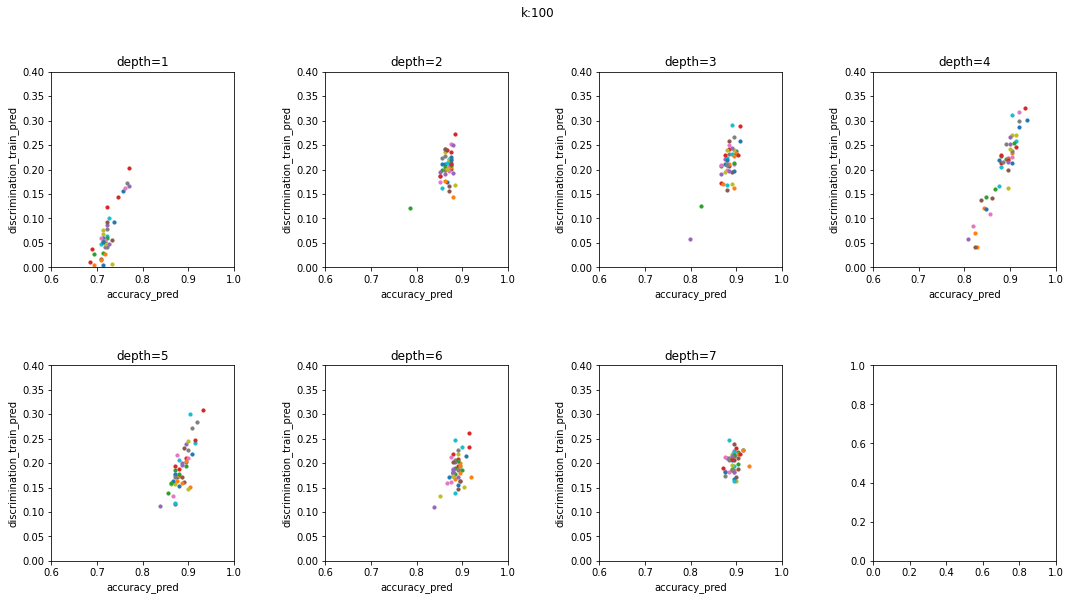

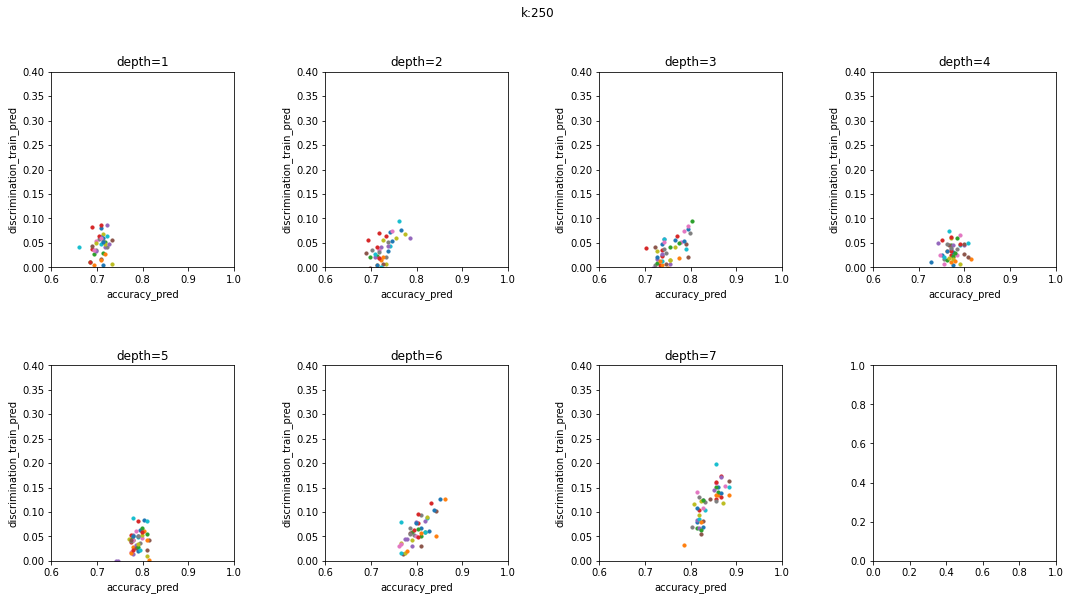

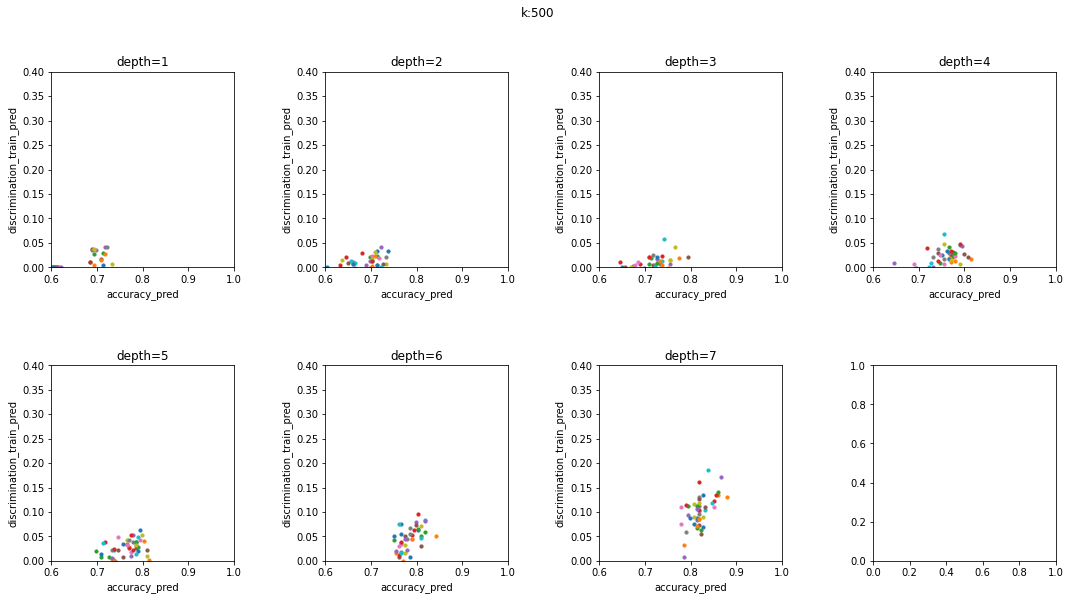

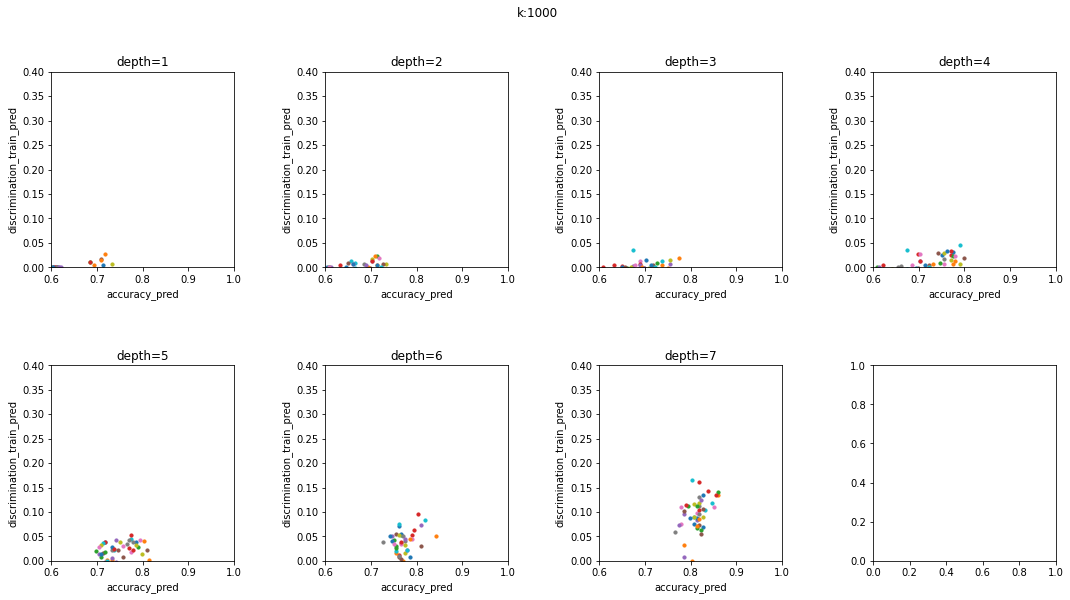

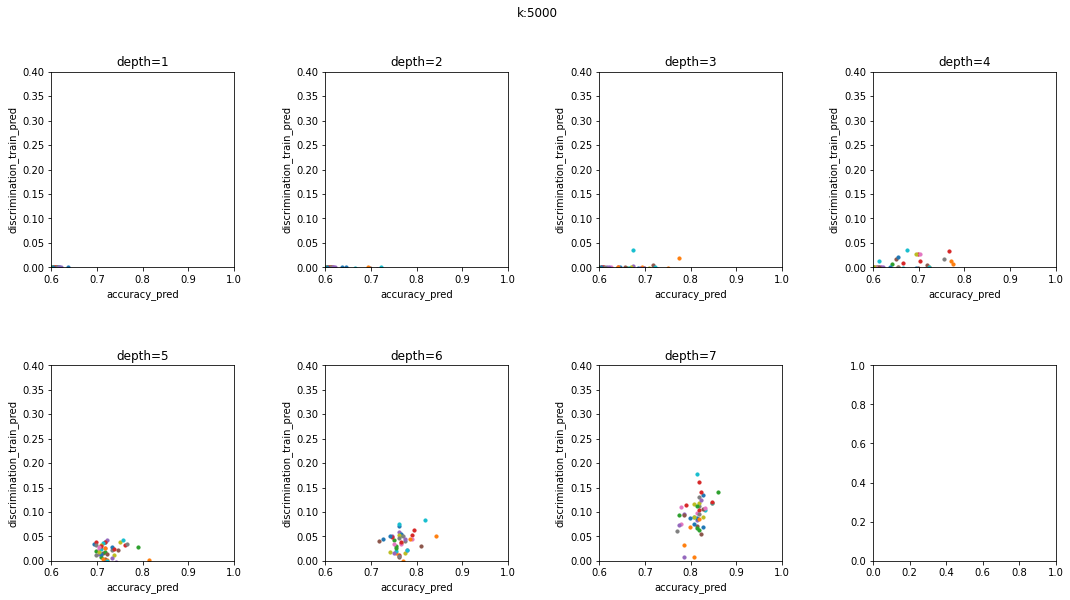

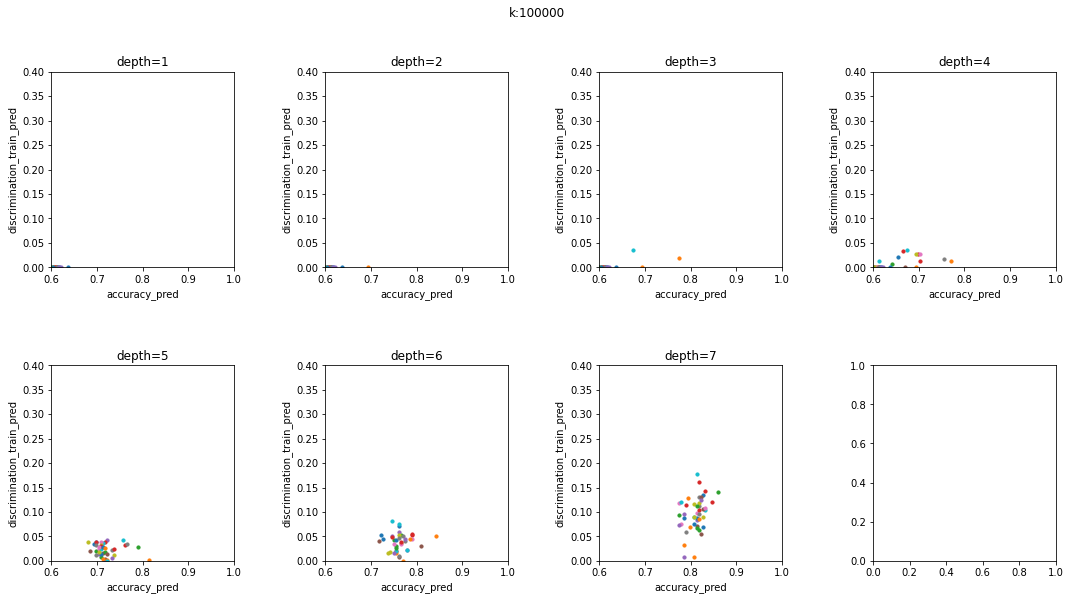

In [26]:
utils.plot_one_scatter_by_depth("accuracy_pred", "discrimination_train_pred", result, (0.6, 1), (0, 0.4))

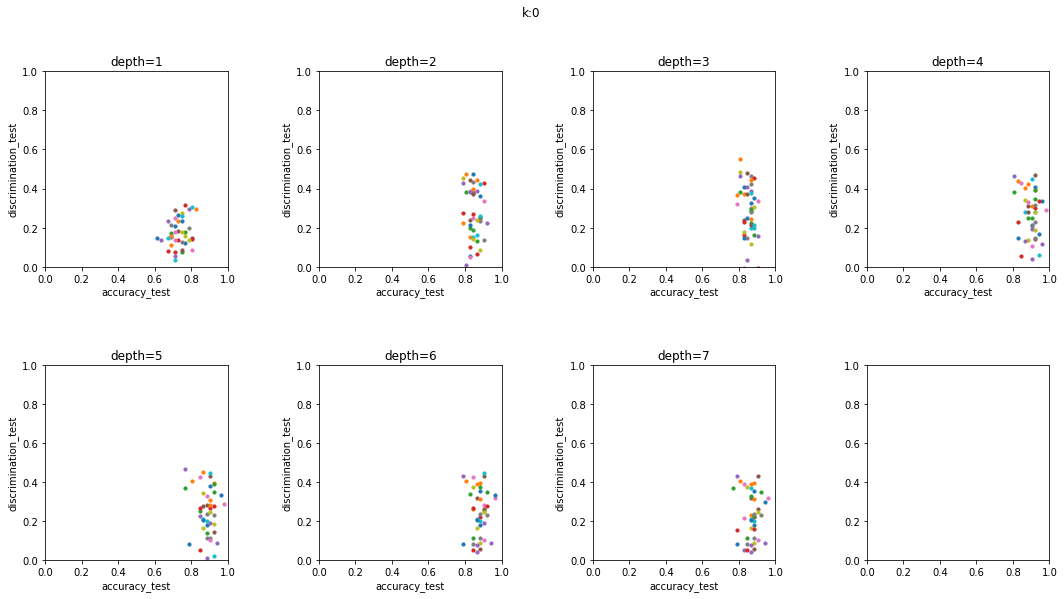

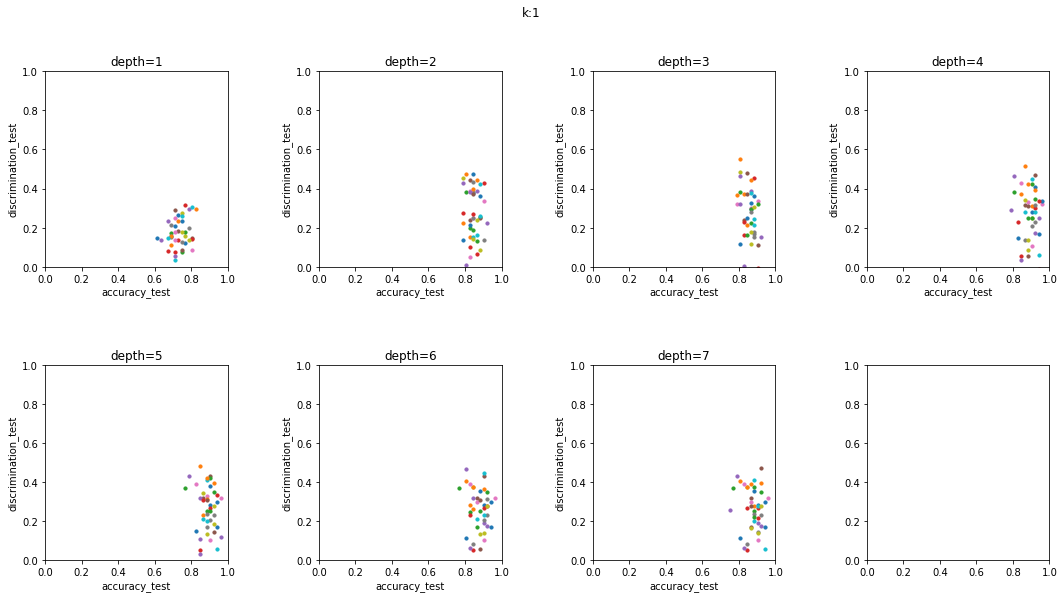

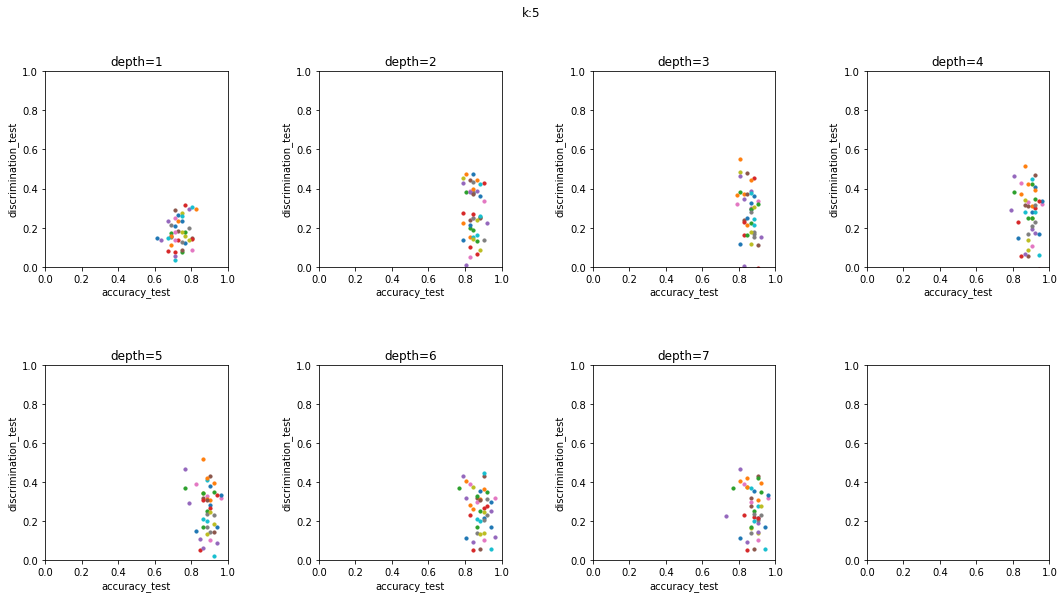

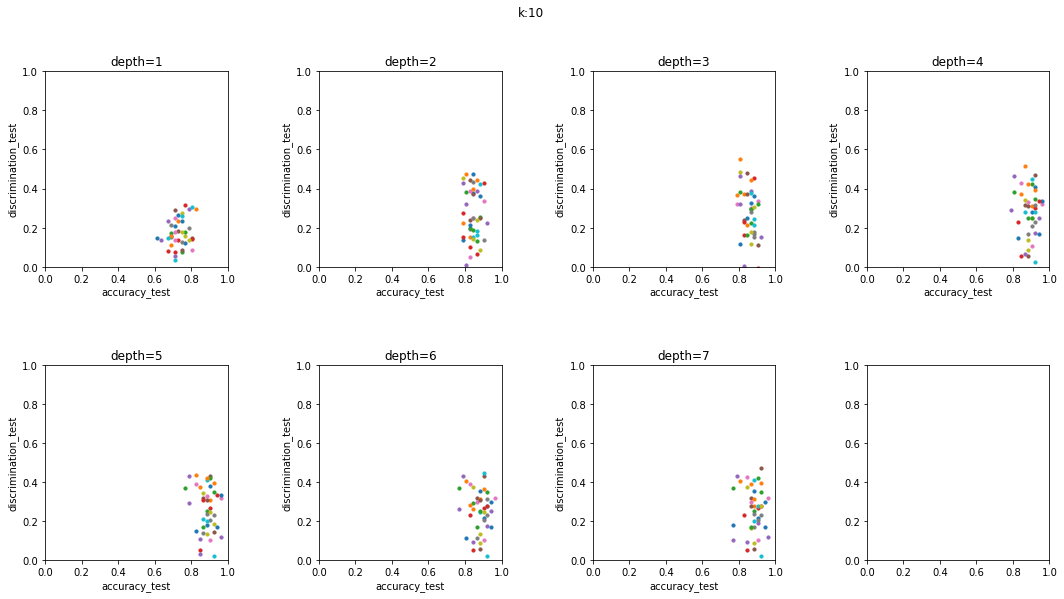

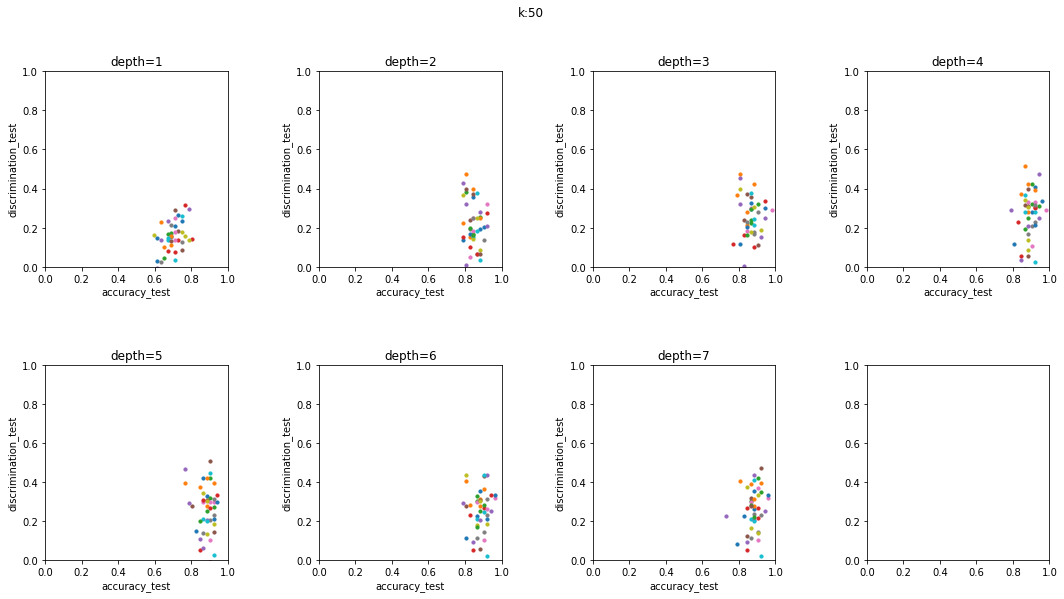

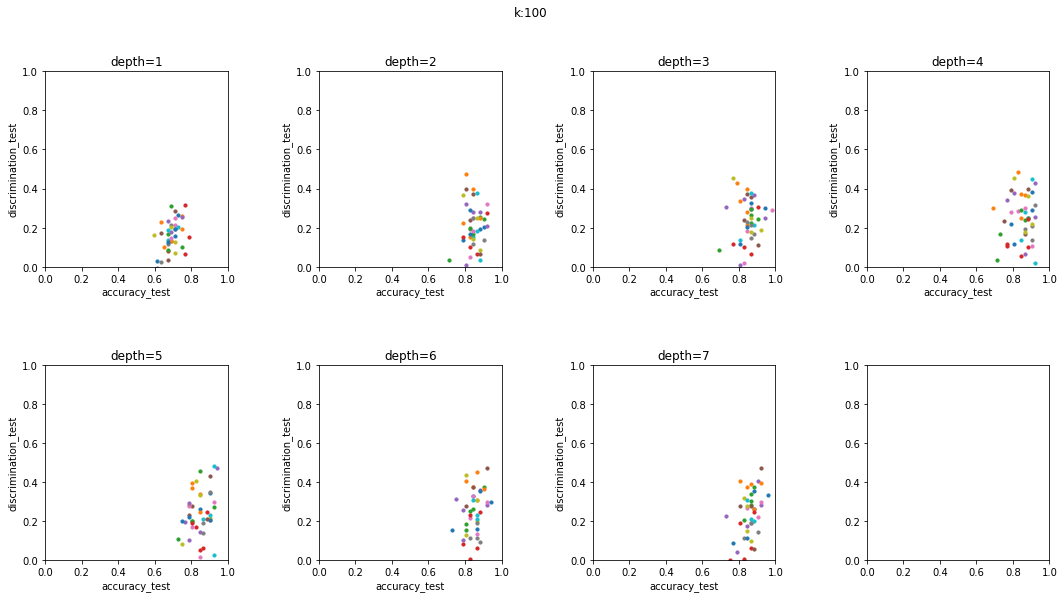

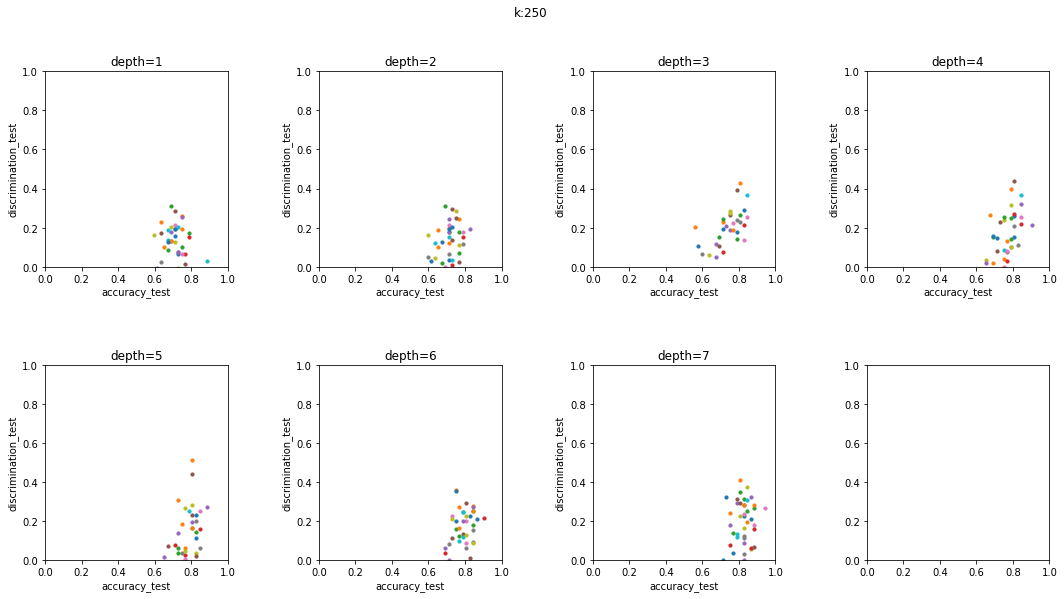

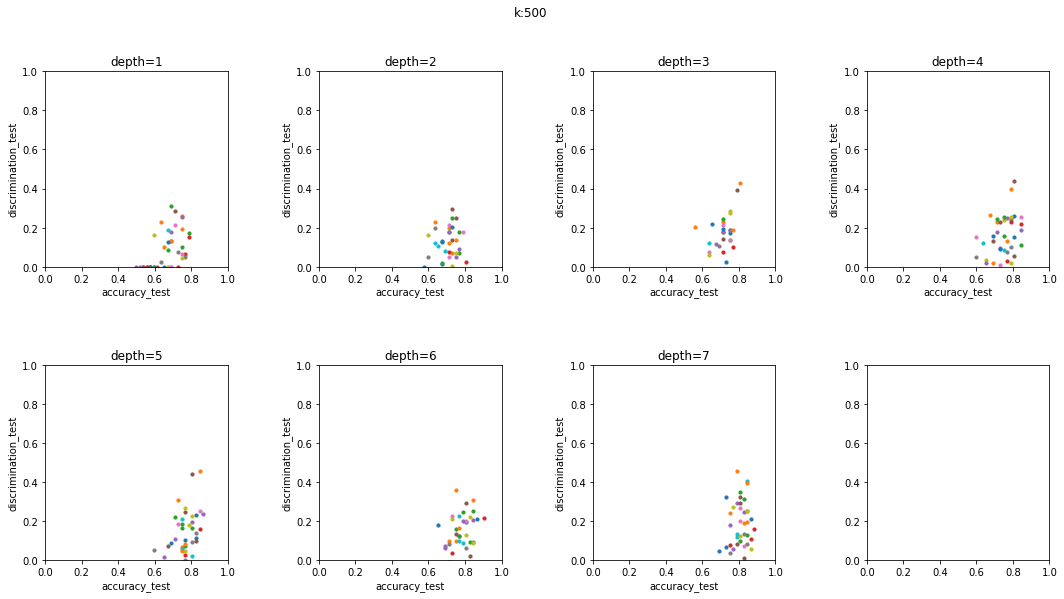

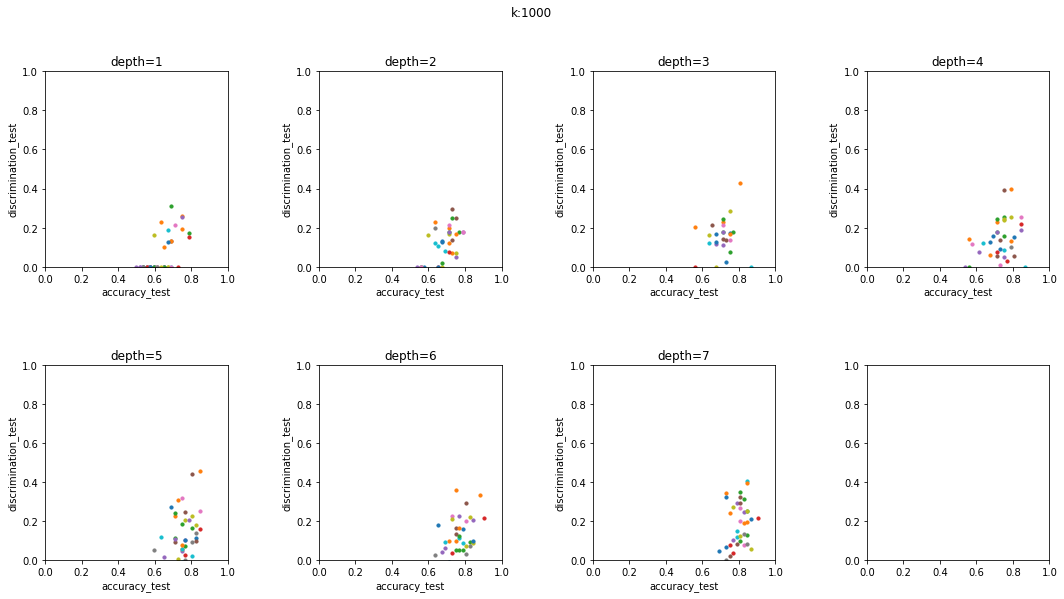

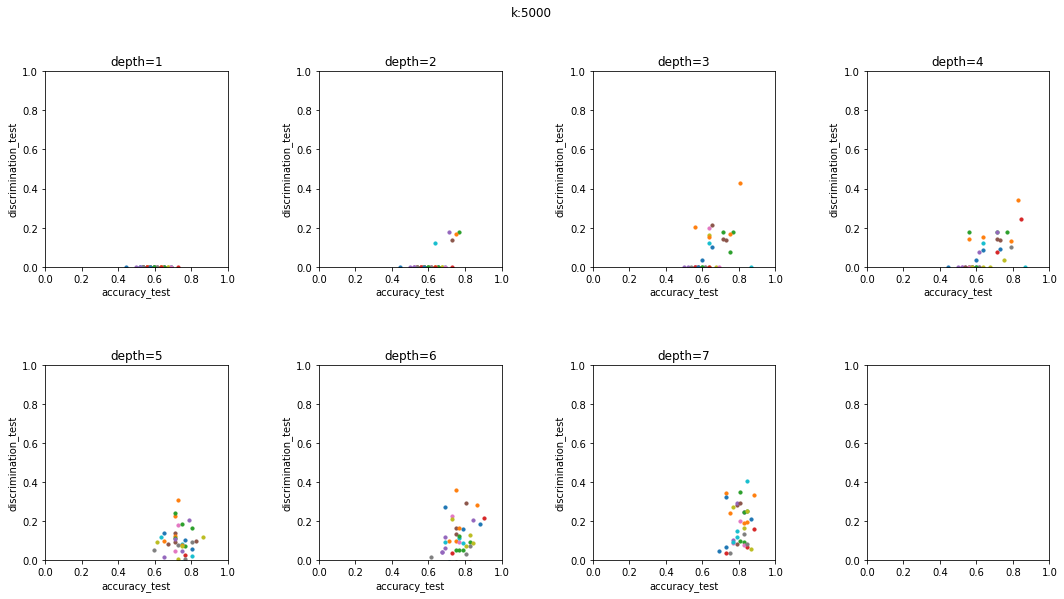

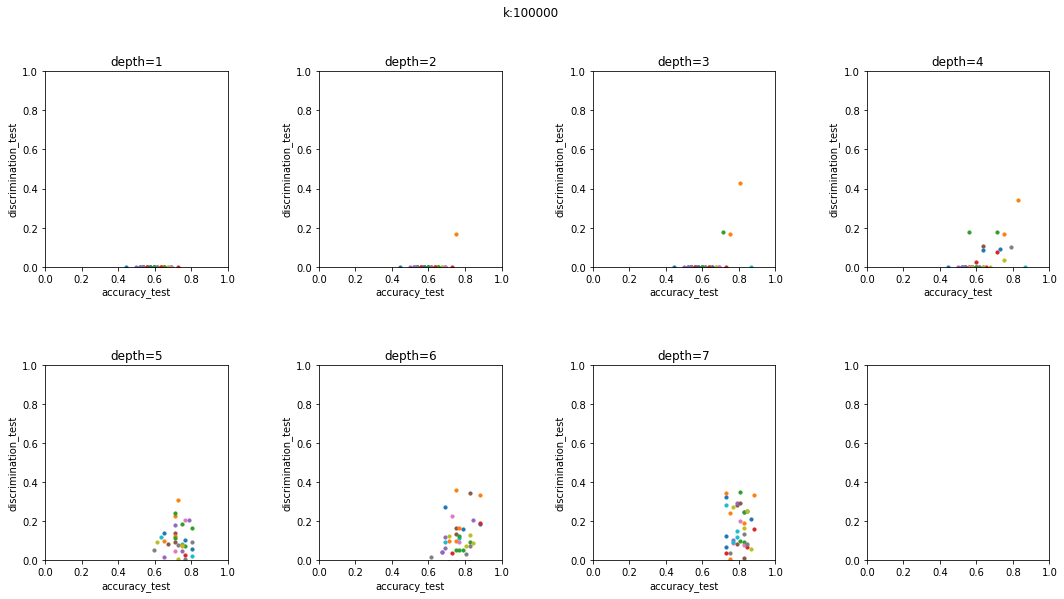

In [27]:
utils.plot_one_scatter_by_depth("accuracy_test", "discrimination_test", result, (0, 1), (0, 1))

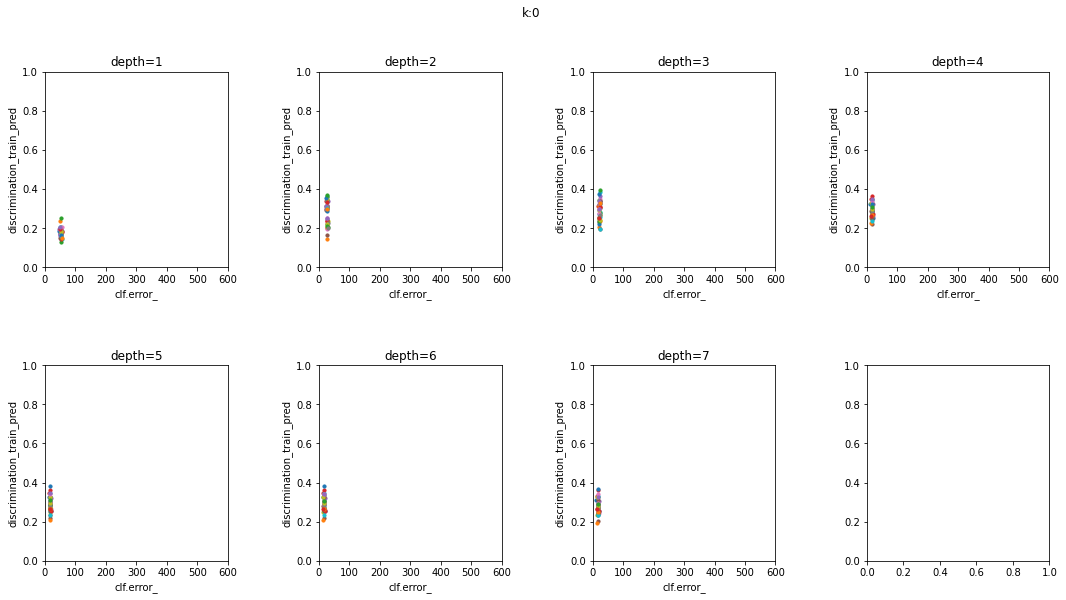

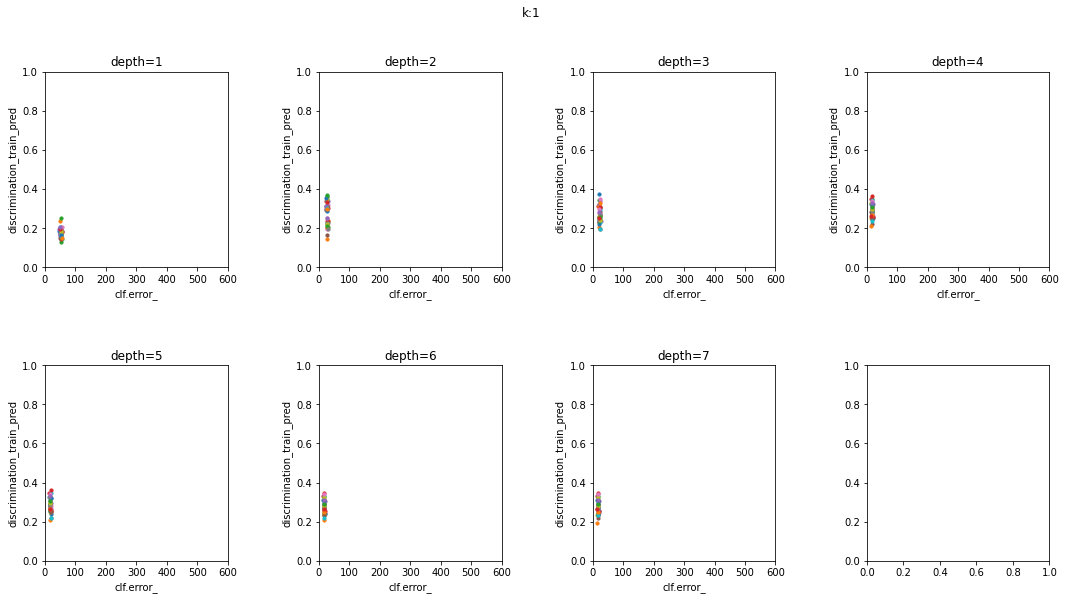

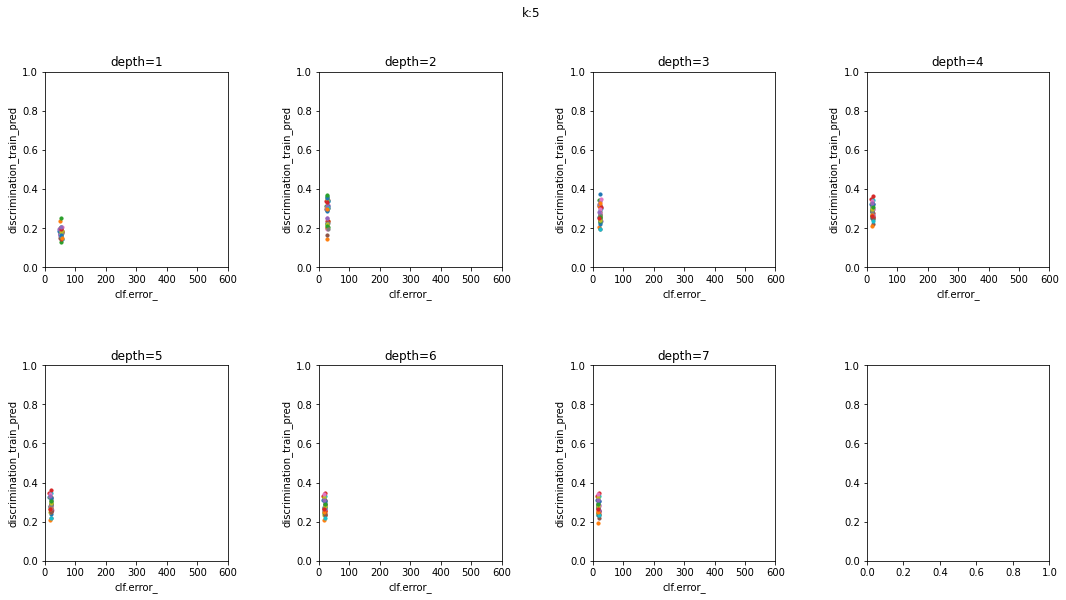

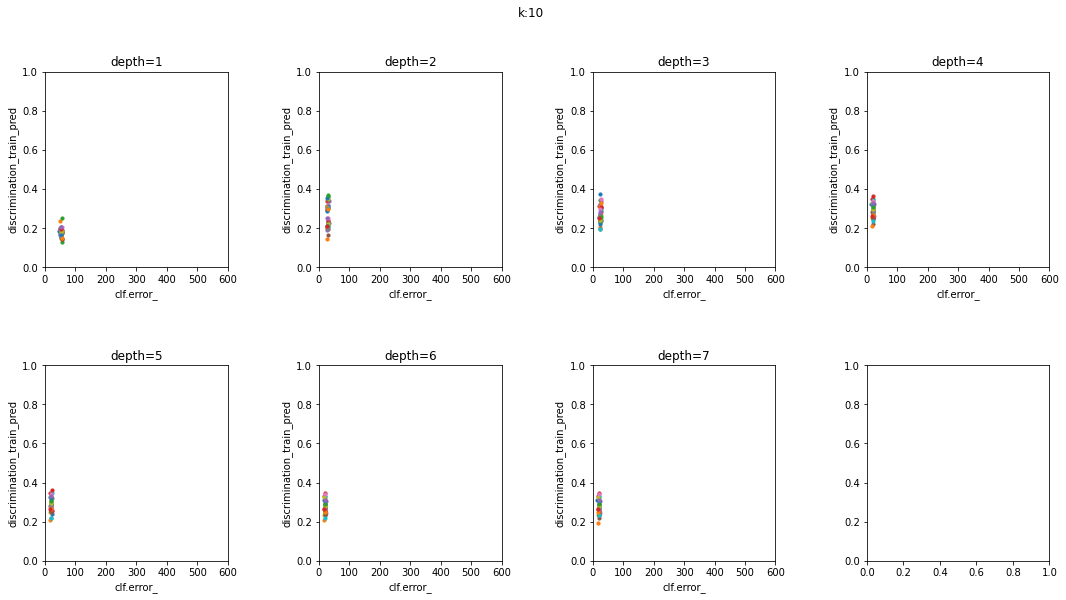

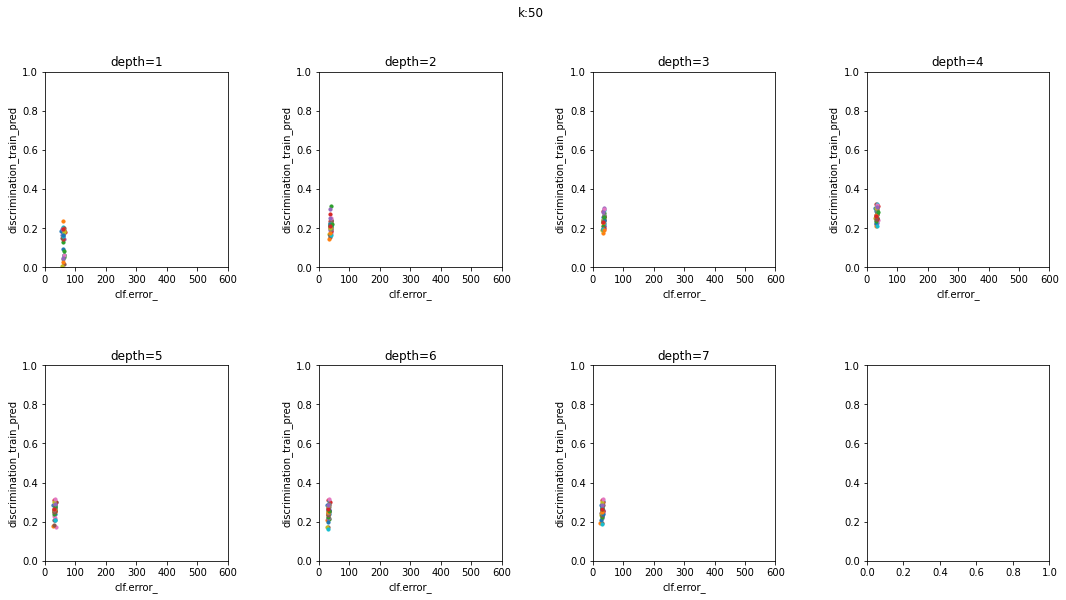

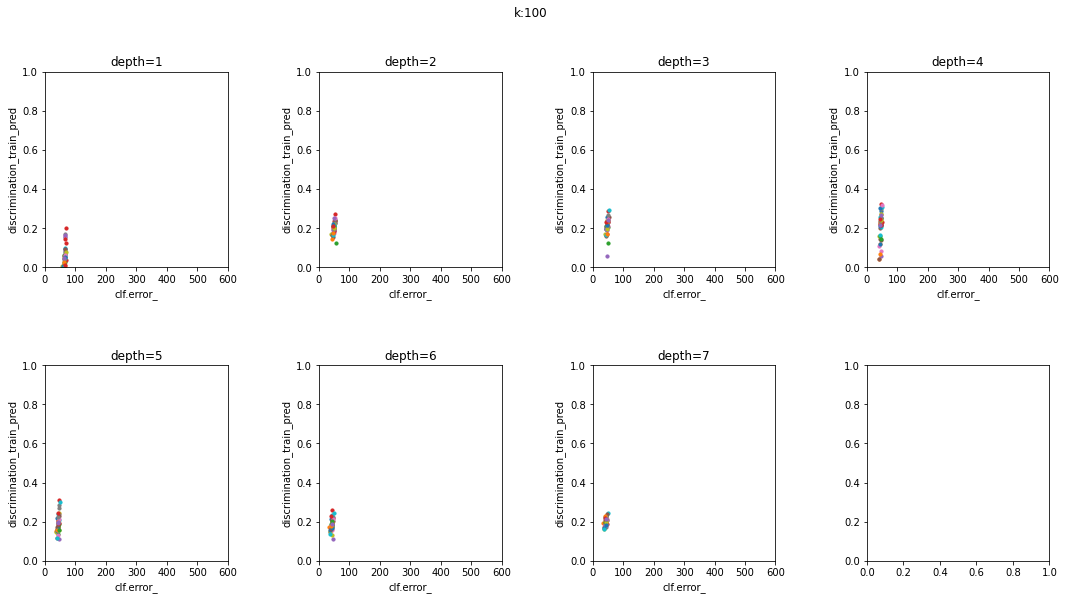

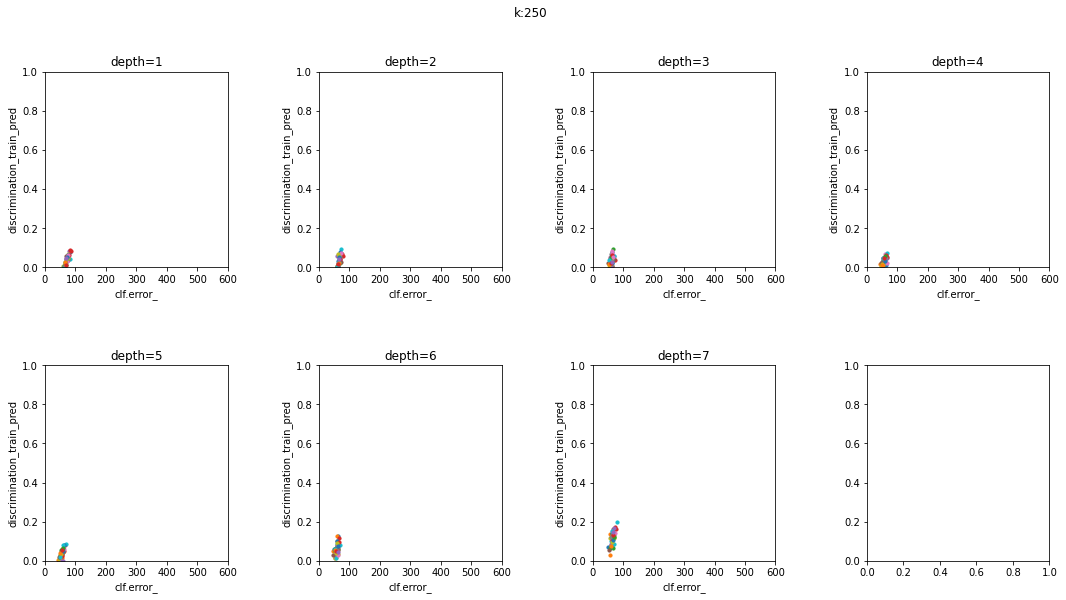

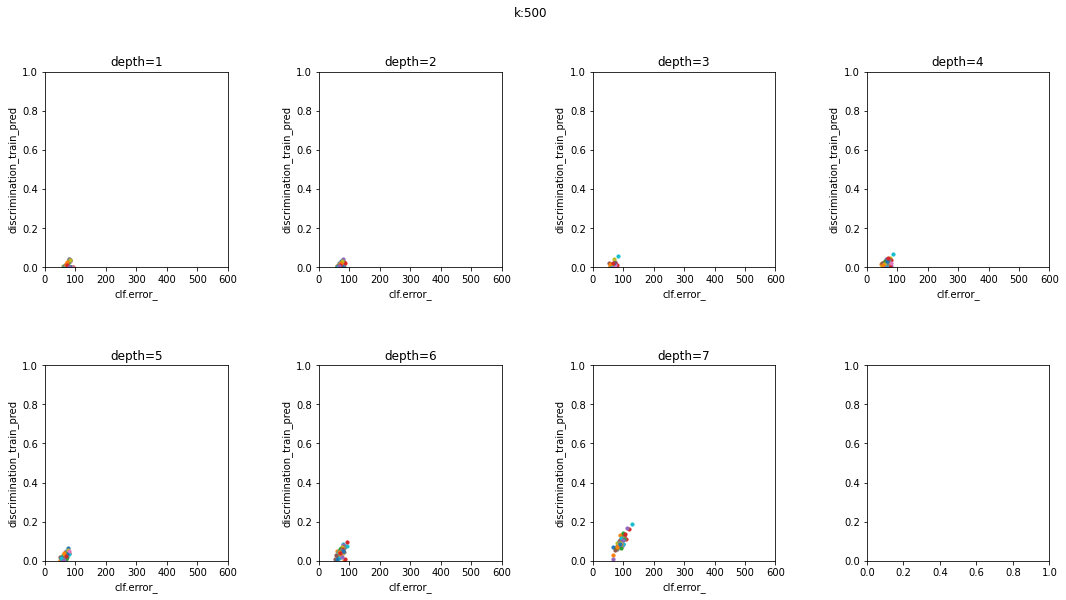

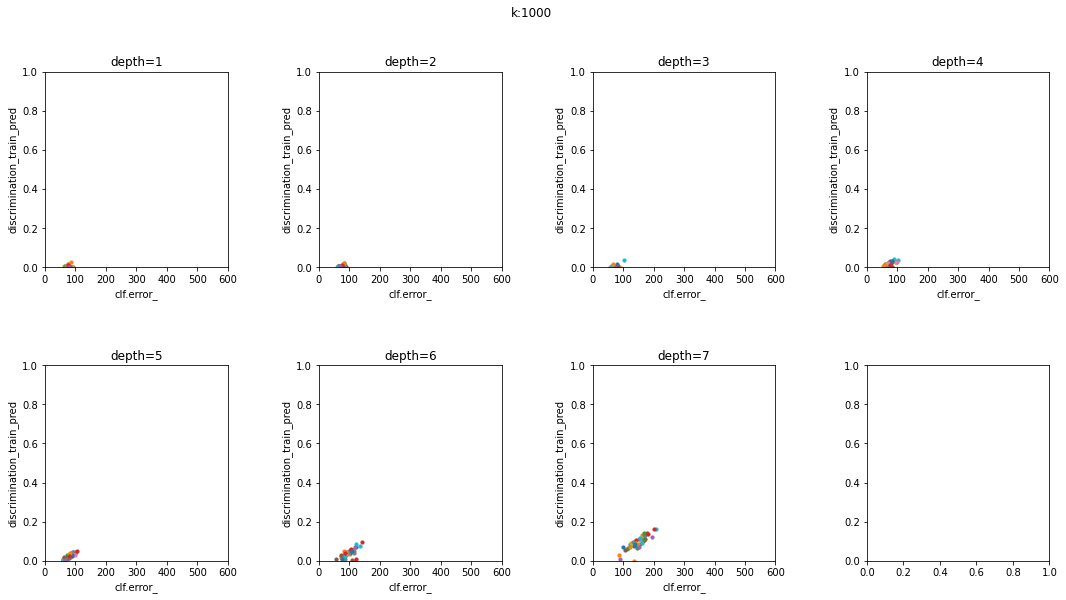

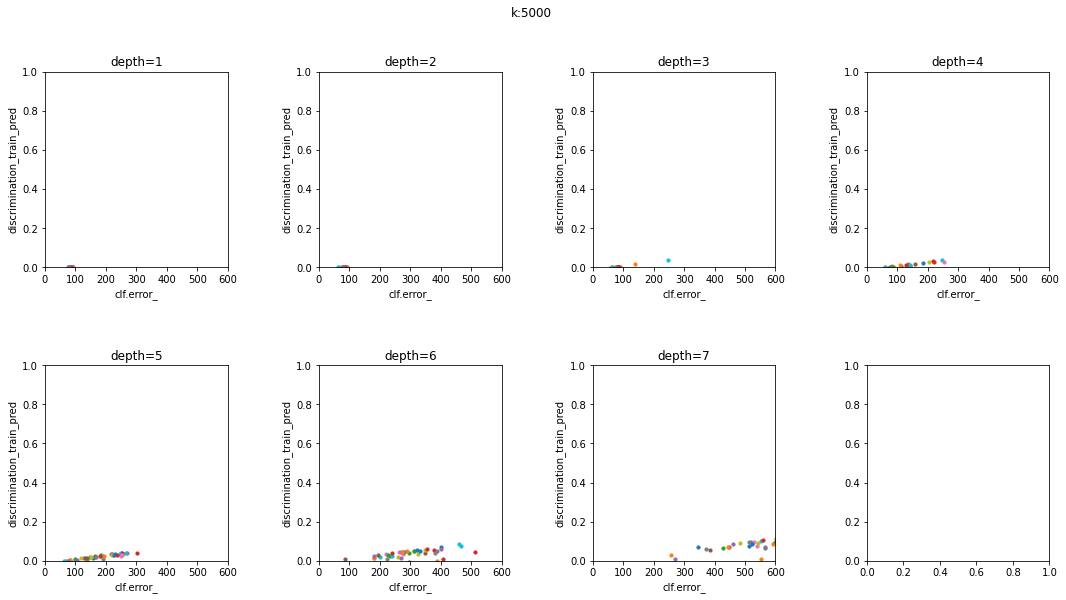

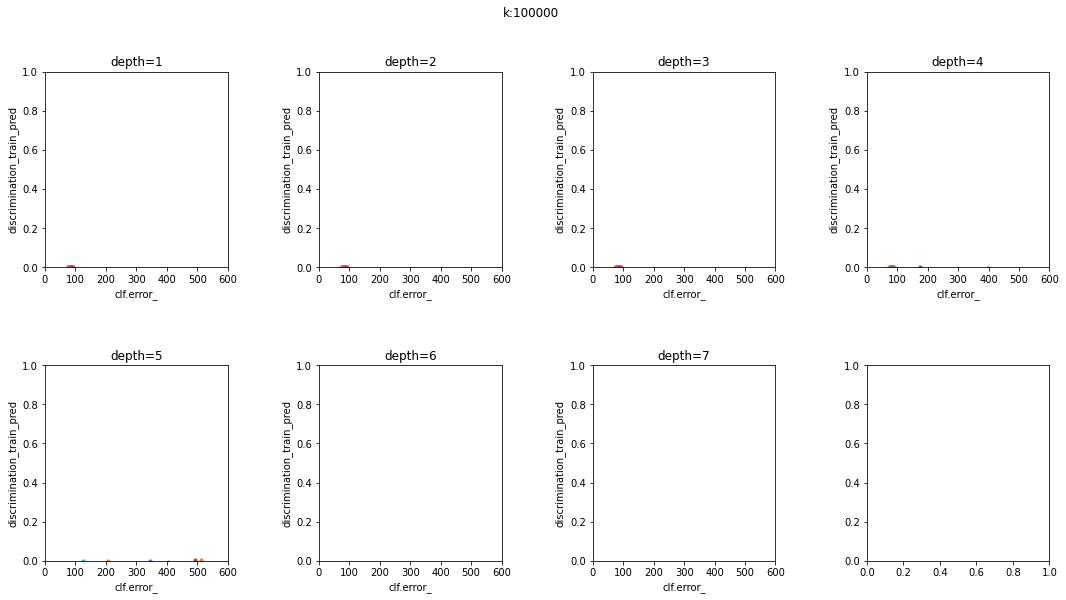

In [28]:
utils.plot_one_scatter_by_depth("clf.error_", "discrimination_train_pred", result, (0, 600), (0, 1))

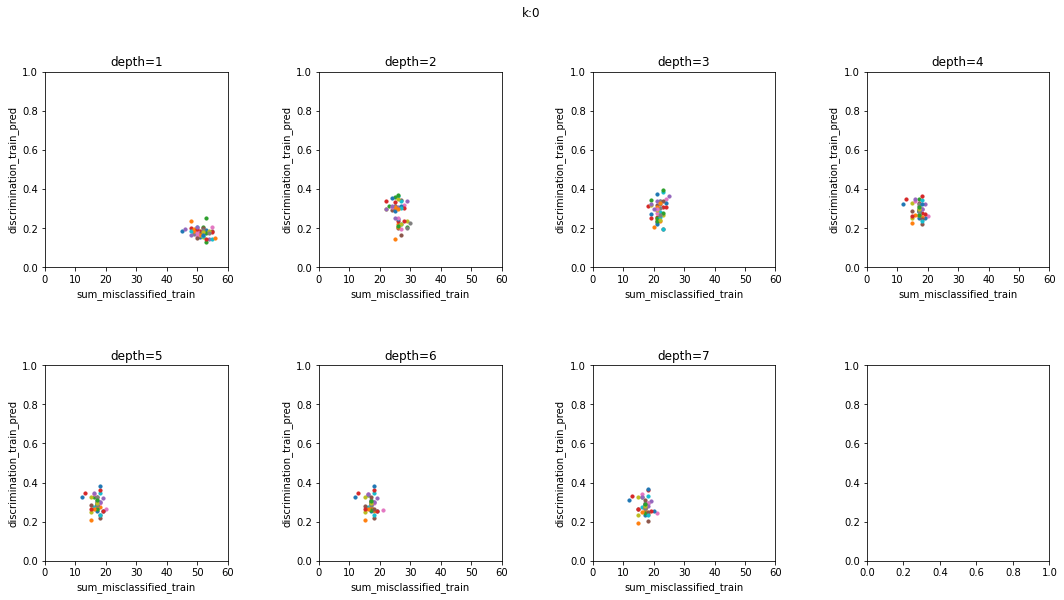

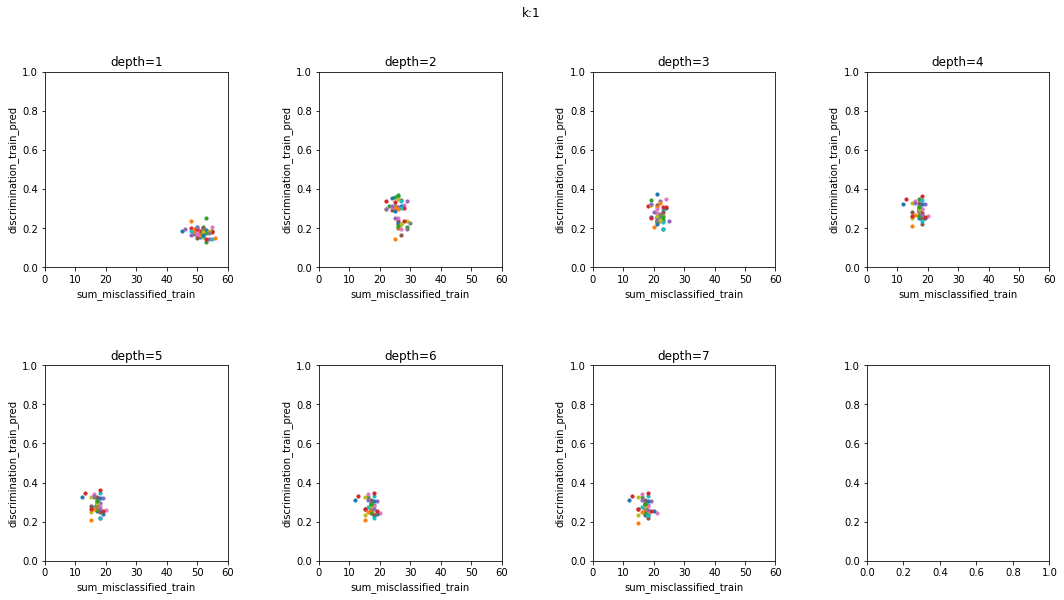

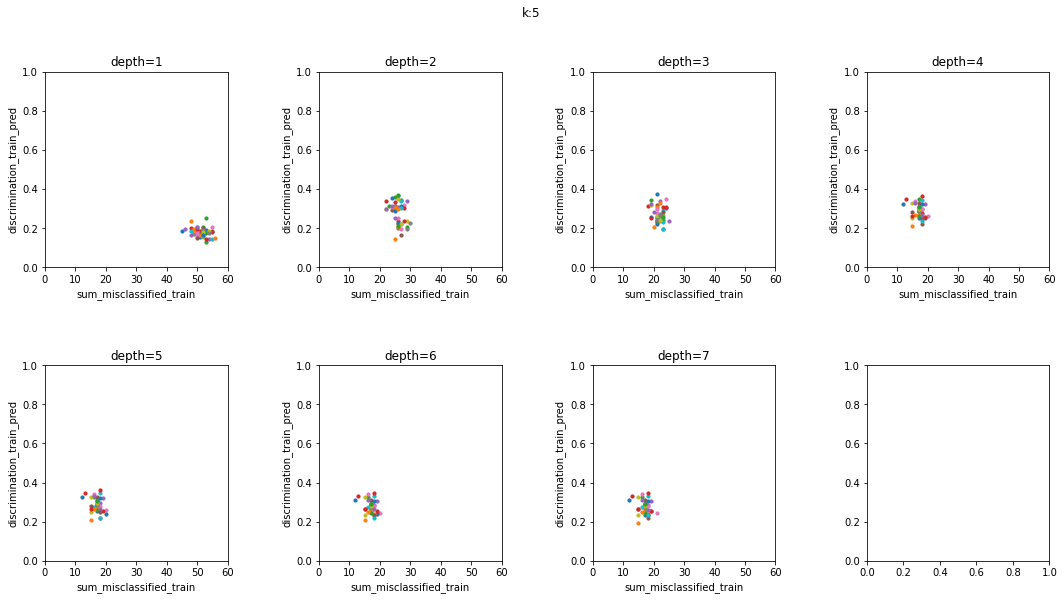

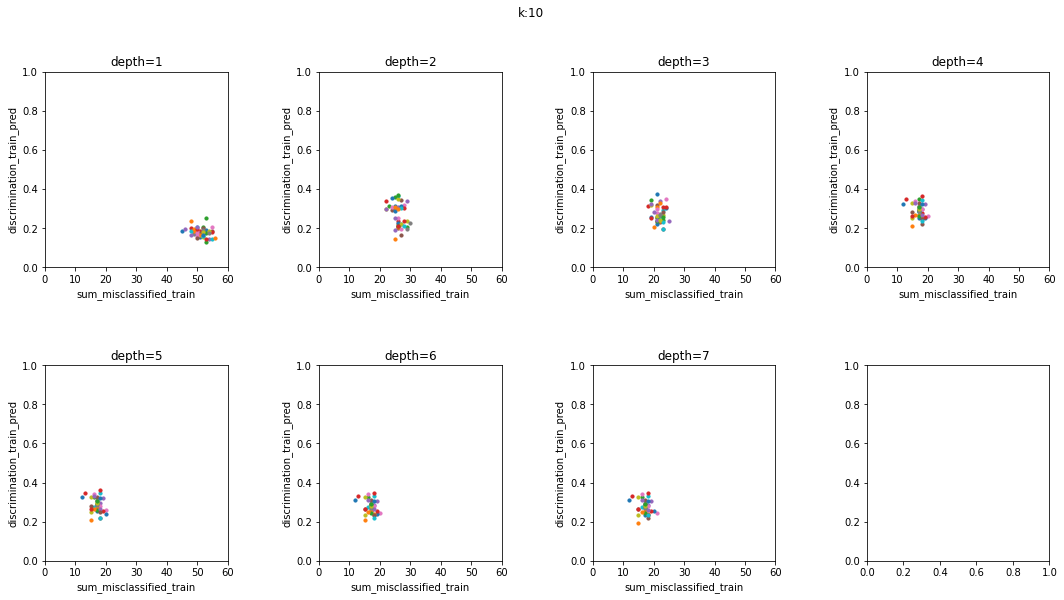

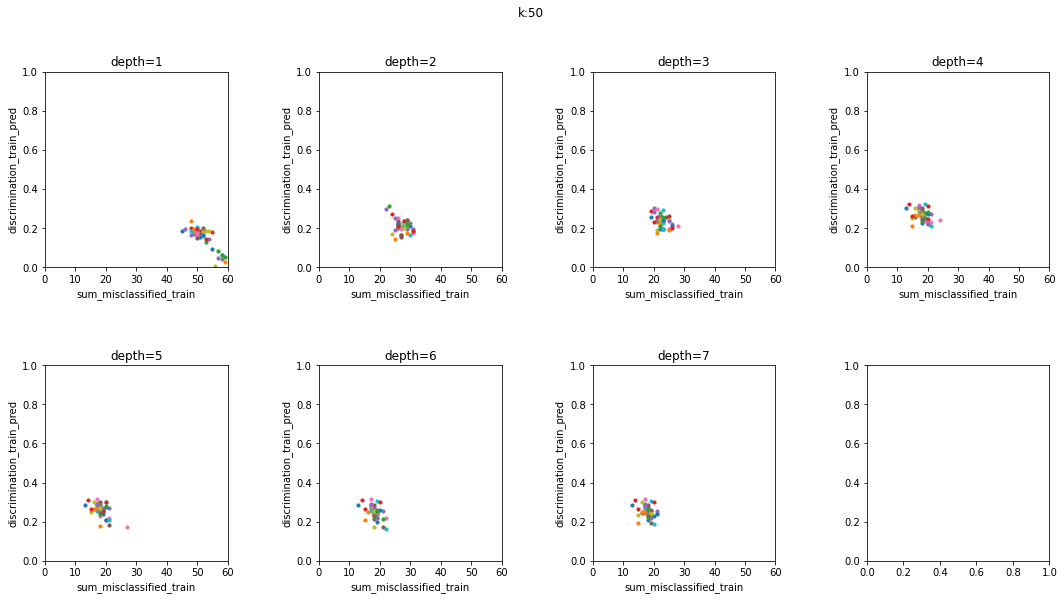

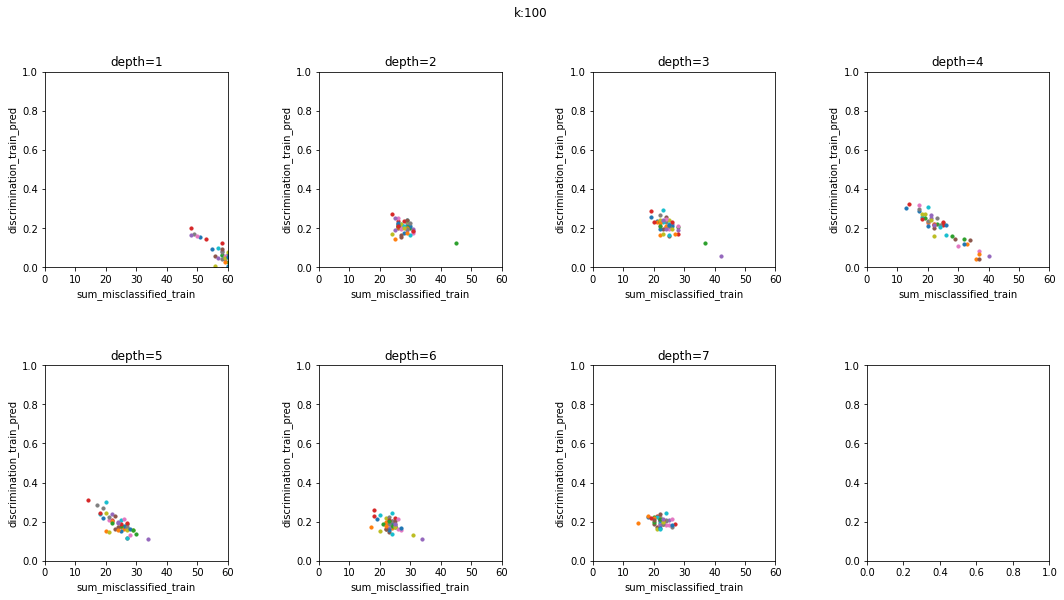

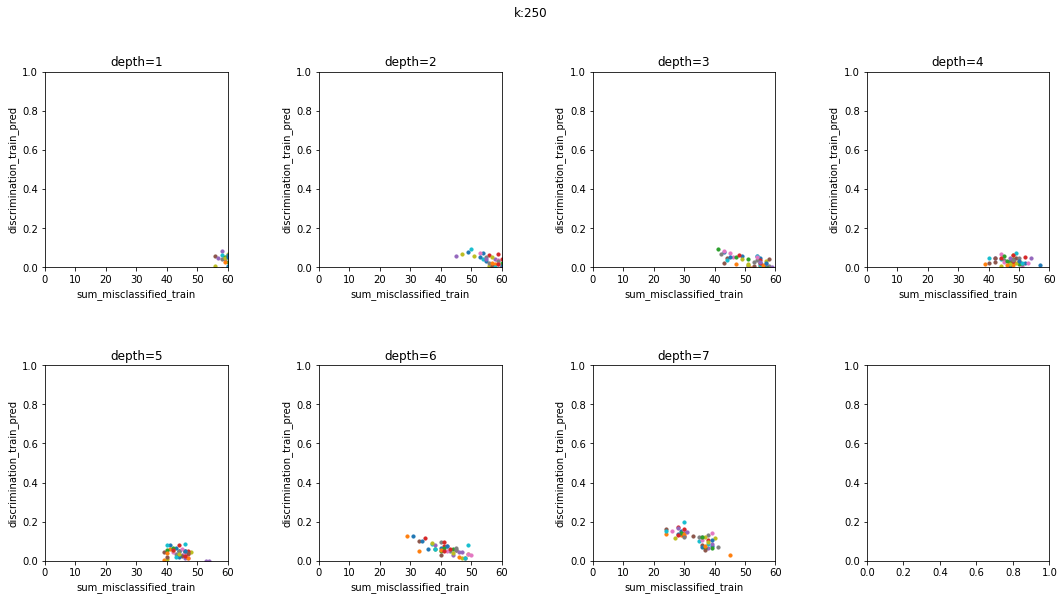

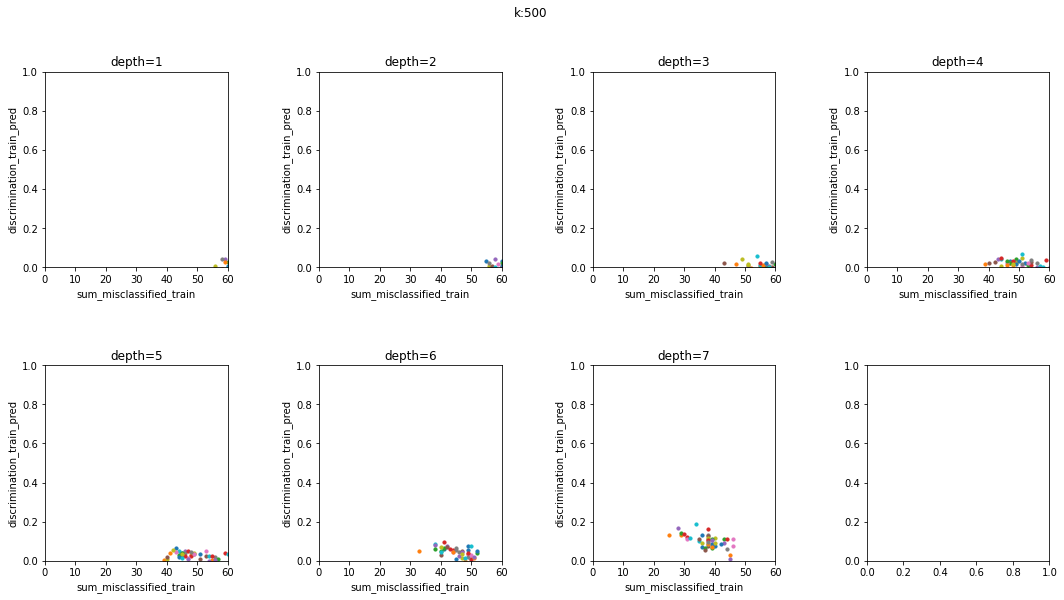

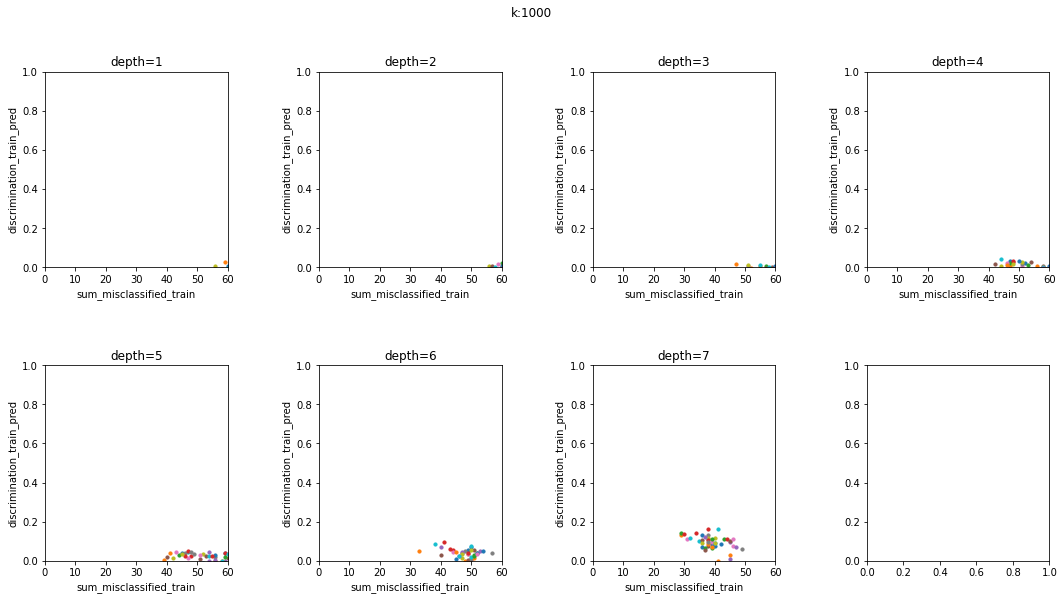

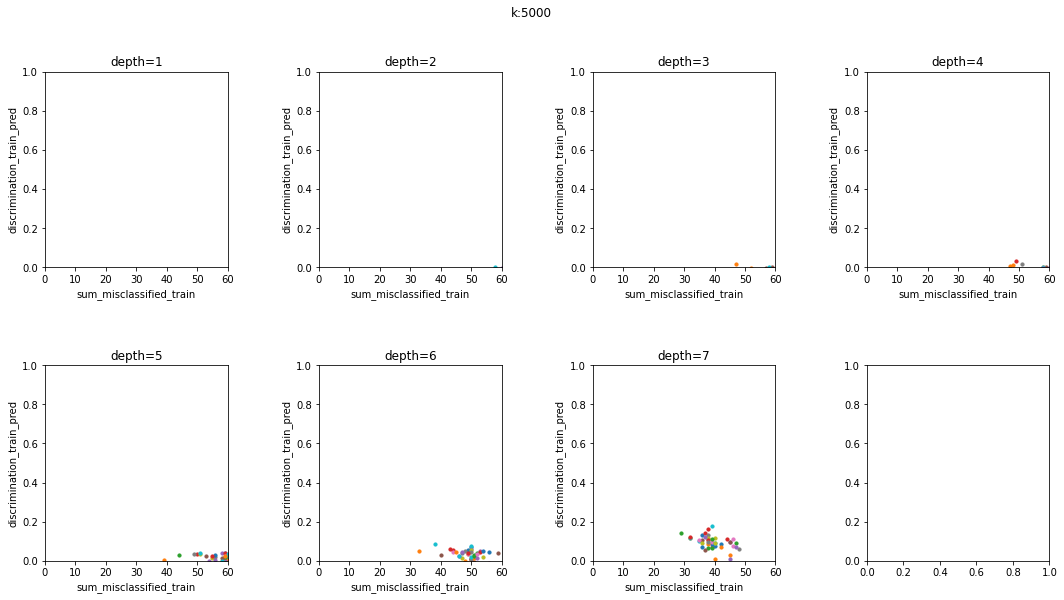

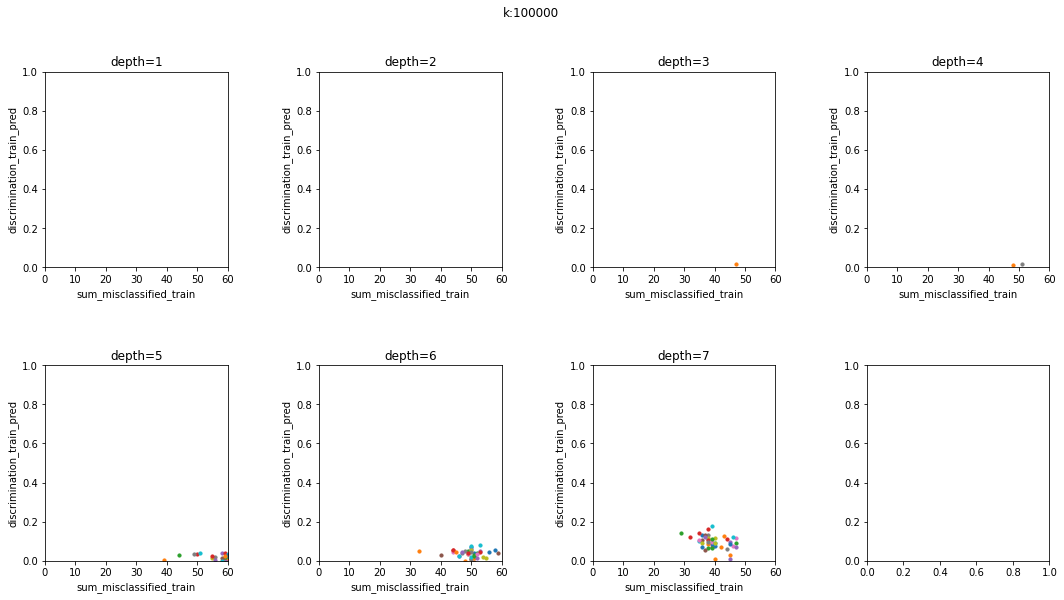

In [29]:
utils.plot_one_scatter_by_depth("sum_misclassified_train", "discrimination_train_pred", result, (0, 60), (0, 1))

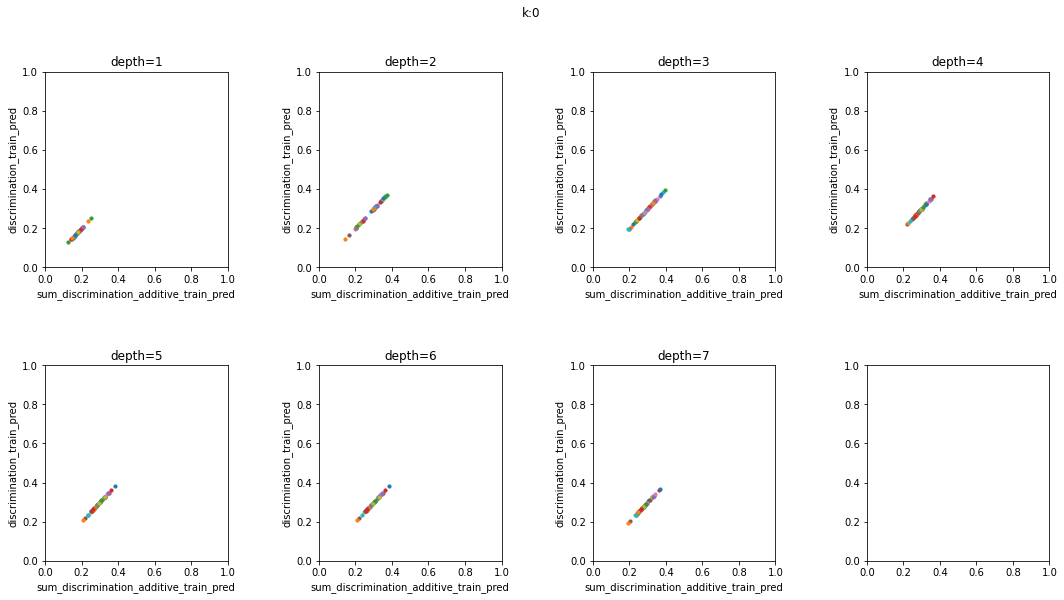

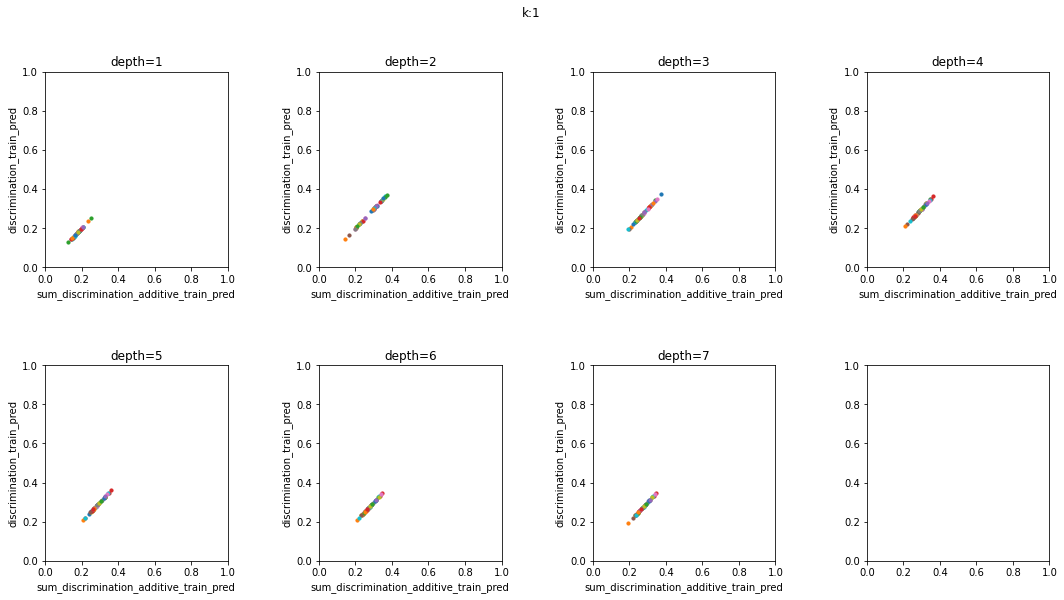

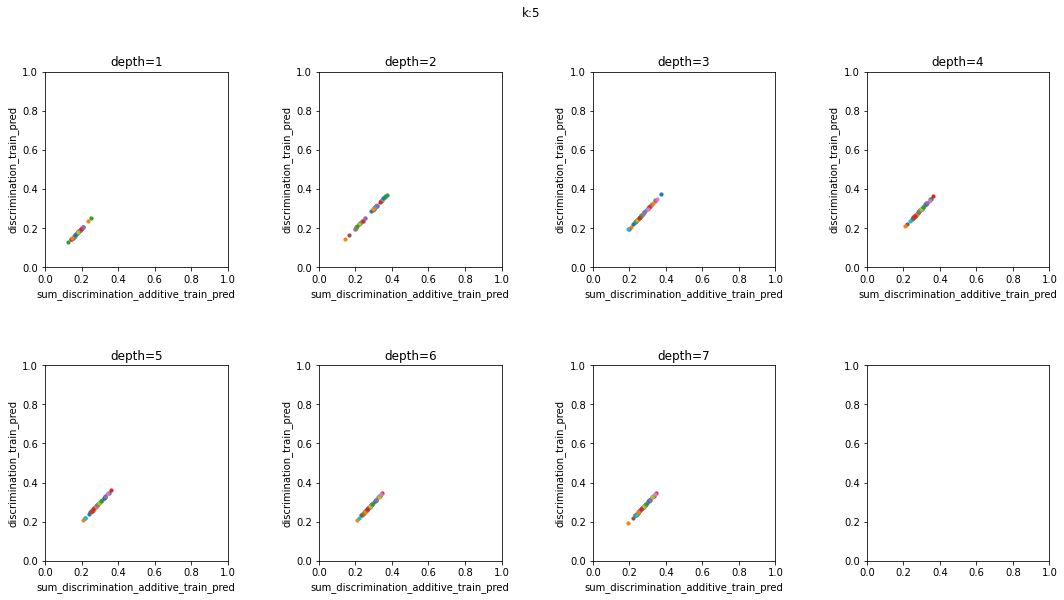

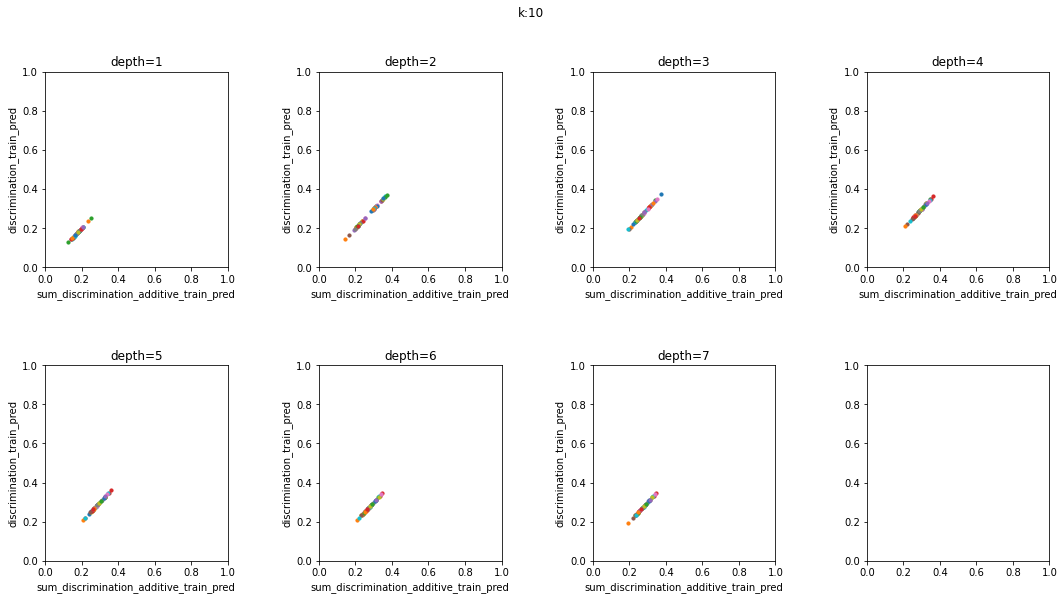

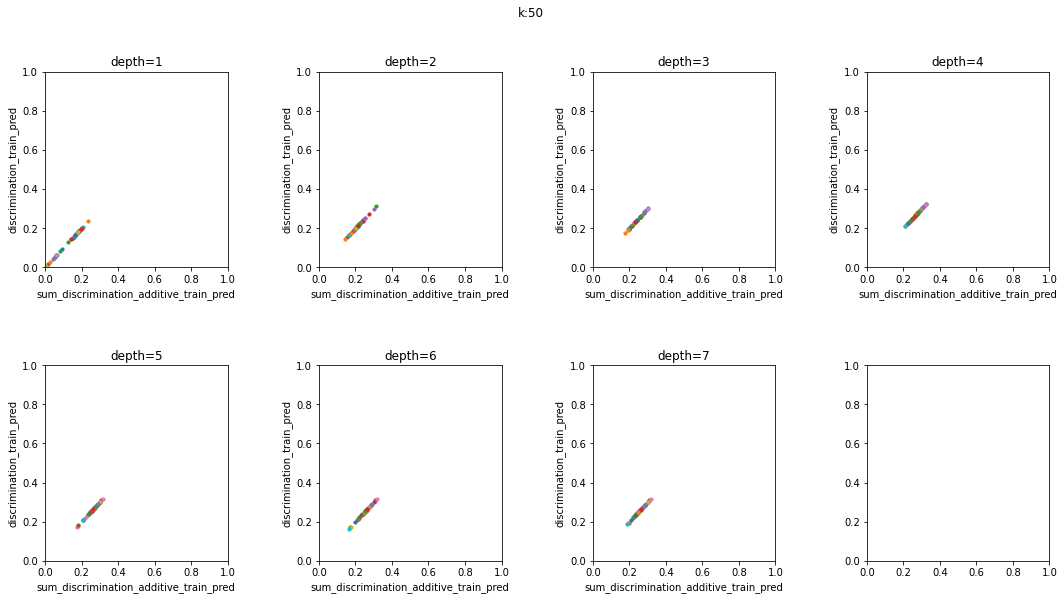

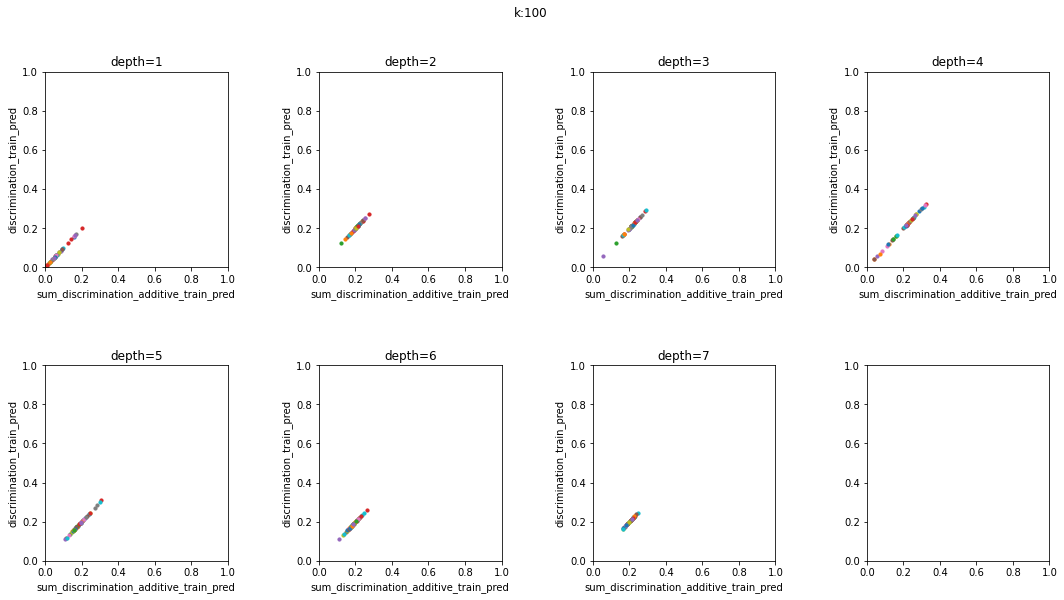

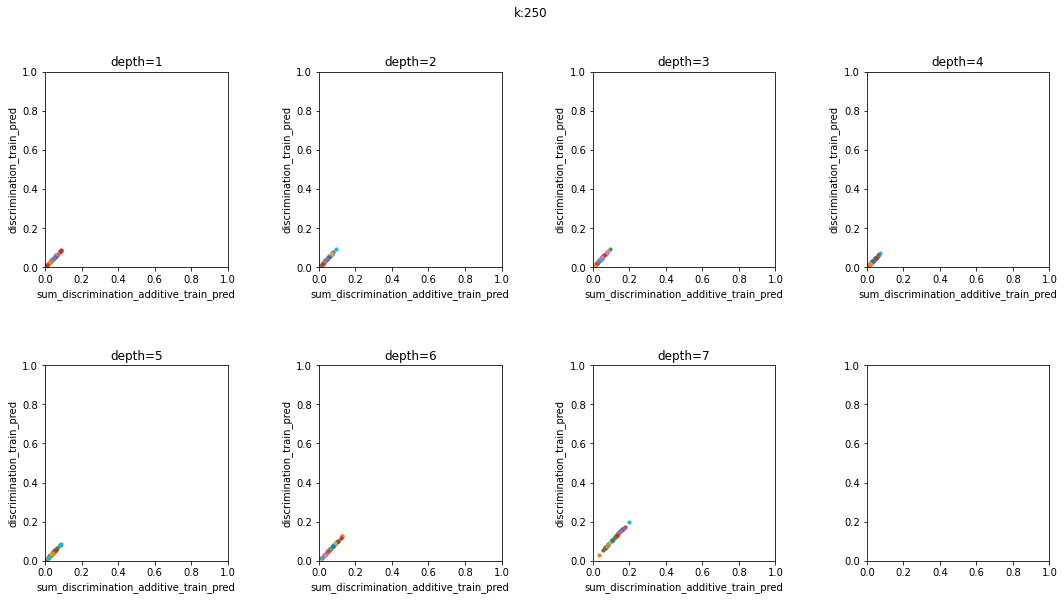

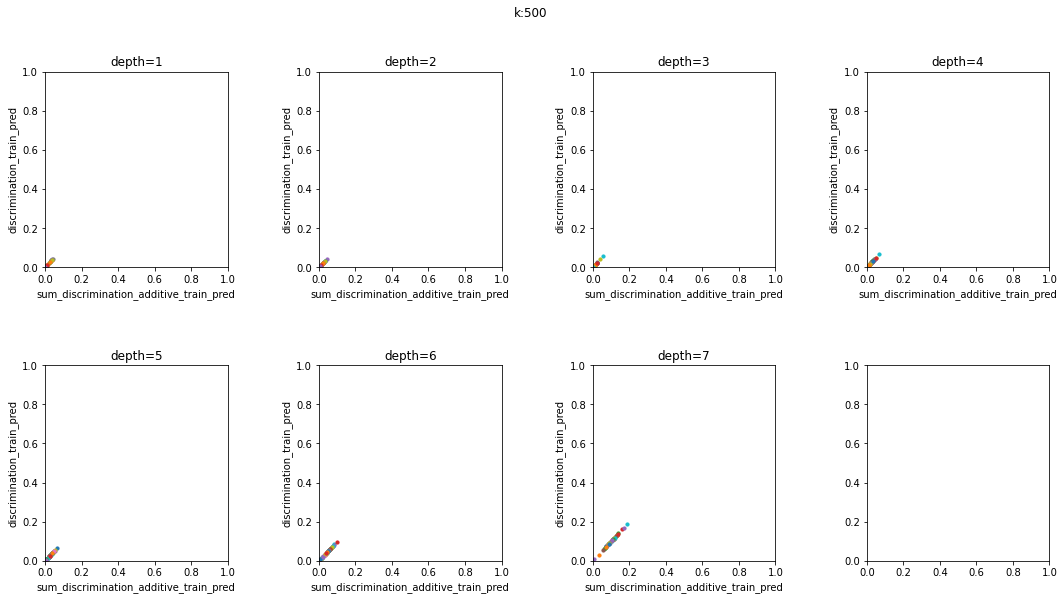

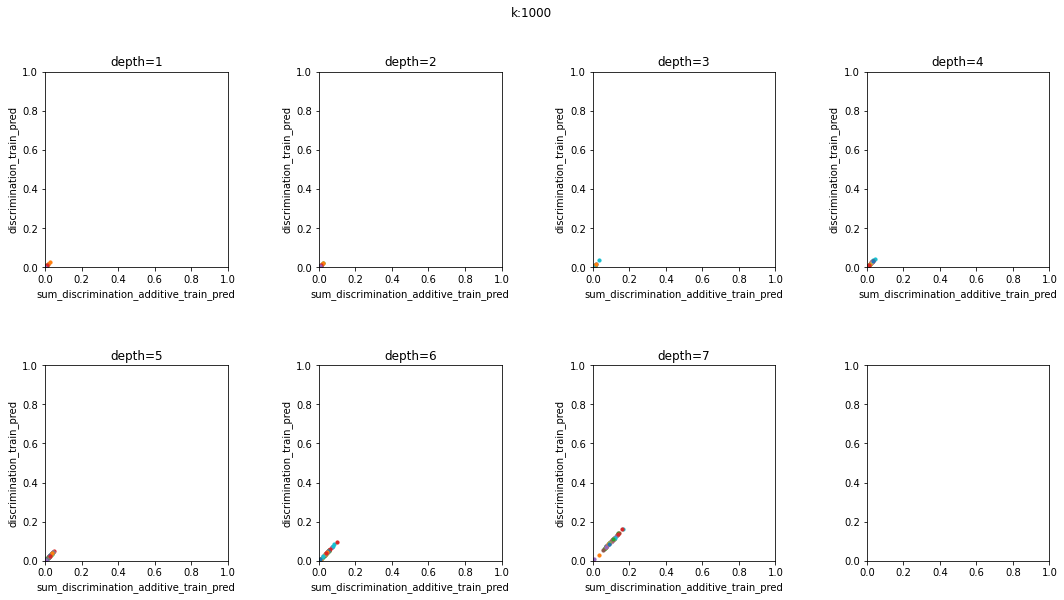

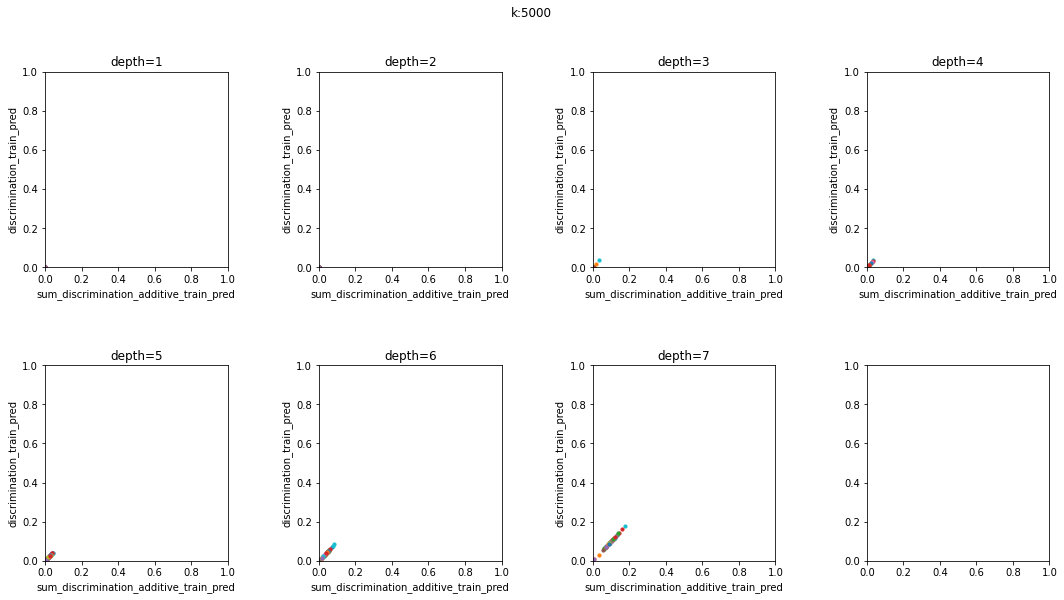

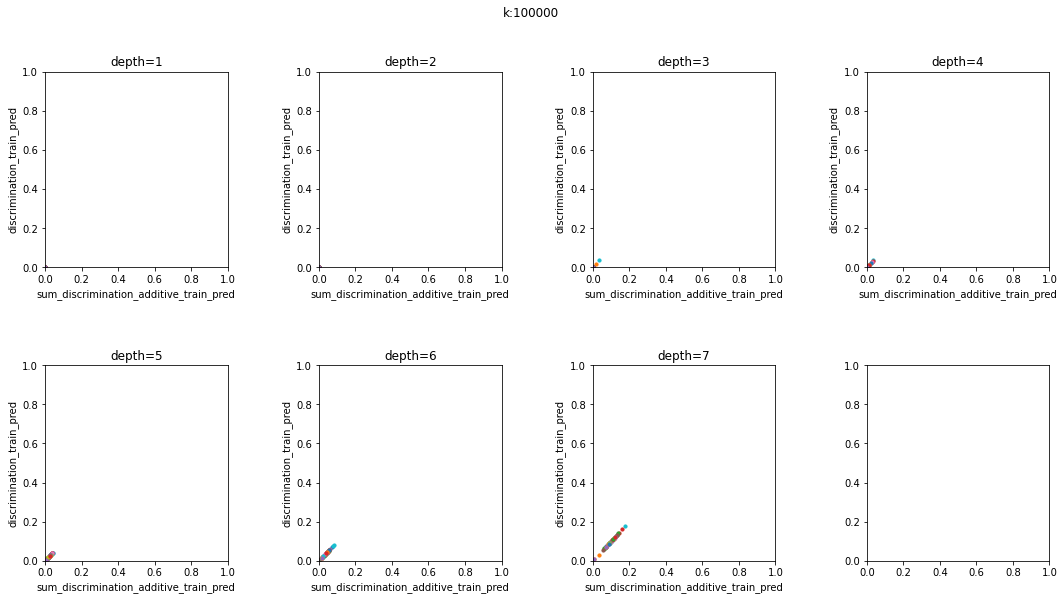

In [30]:
utils.plot_one_scatter_by_depth("sum_discrimination_additive_train_pred", "discrimination_train_pred", result, (0, 1), (0, 1))

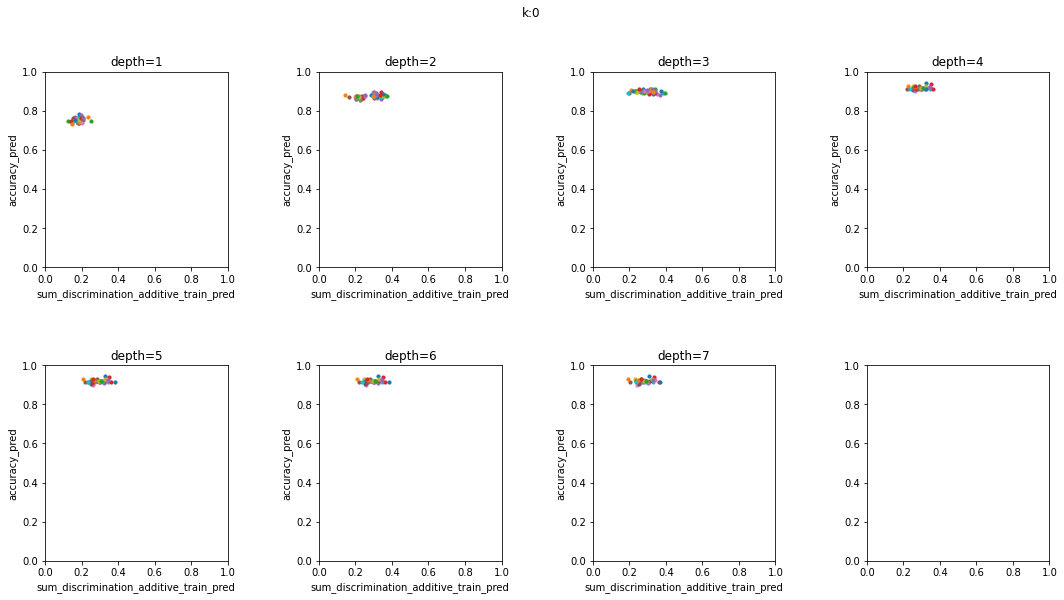

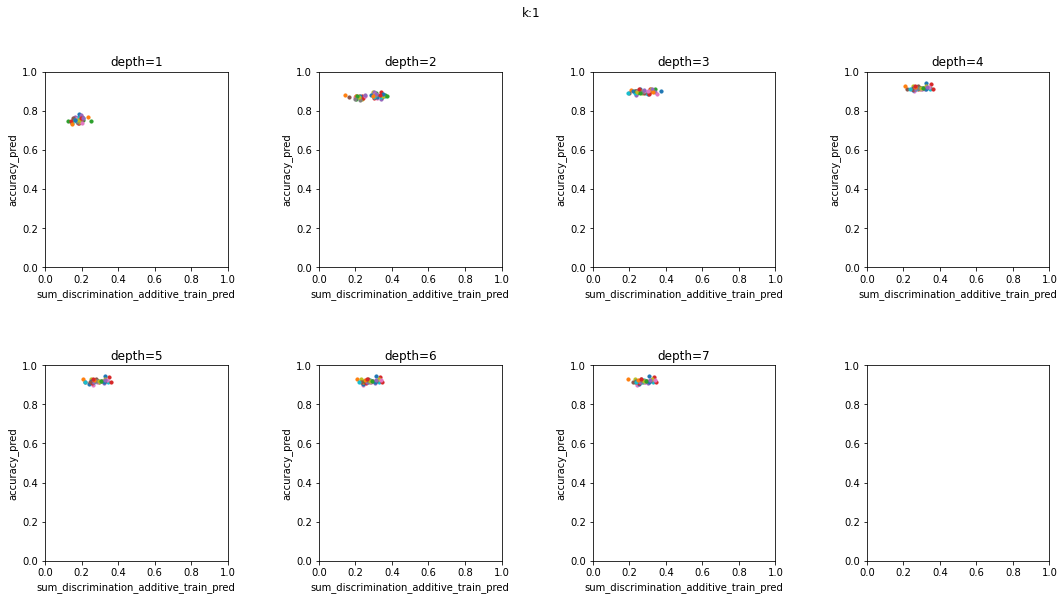

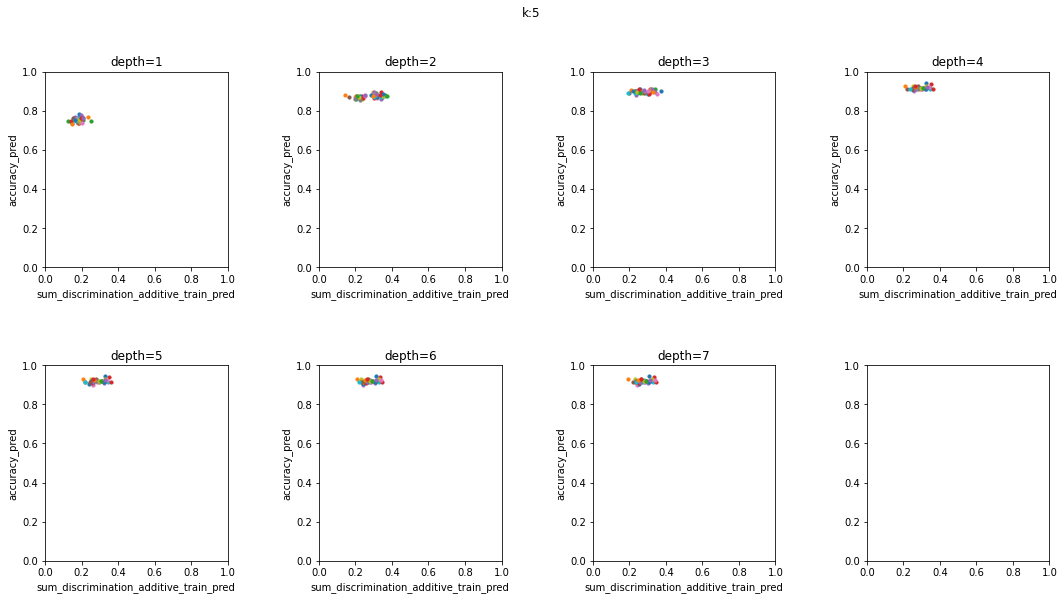

In [ ]:
utils.plot_one_scatter_by_depth("sum_discrimination_additive_train_pred", "accuracy_pred", result, (0, 1), (0, 1))

In [ ]:
x_lim = (0.84, 0.95)
y_lim = (0.2, 0.3)
utils.plot_k_depth_mean("accuracy_pred", "discrimination_train_pred", result, x_lim, y_lim)
utils.plot_each_k_depth_mean("accuracy_pred", "discrimination_train_pred", result, x_lim, y_lim)

In [ ]:
x_lim = (0.84, 0.95)
y_lim = (0.2, 0.3)
utils.plot_k_depth_mean("accuracy_test", "discrimination_test", result, x_lim, y_lim)
utils.plot_each_k_depth_mean("accuracy_test", "discrimination_test", result, x_lim, y_lim)

In [ ]:
x_lim = None
y_lim = None
utils.plot_k_depth_mean("clf.error_", "discrimination_train_pred", result, x_lim, y_lim)
utils.plot_each_k_depth_mean("clf.error_", "discrimination_train_pred", result, x_lim, y_lim)

In [ ]:
x_lim = None
y_lim = None
utils.plot_k_depth_mean("sum_misclassified_train", "discrimination_train_pred", result, x_lim, y_lim)
utils.plot_each_k_depth_mean("sum_misclassified_train", "discrimination_train_pred", result, x_lim, y_lim)

In [ ]:
x_lim = None
y_lim = None
utils.plot_k_depth_mean("sum_misclassified_train", "discrimination_train_pred", result, x_lim, y_lim)
utils.plot_each_k_depth_mean("sum_misclassified_train", "discrimination_train_pred", result, x_lim, y_lim)

In [ ]:
x_lim = None
y_lim = None
utils.plot_k_depth_mean("sum_discrimination_additive_train_pred", "discrimination_train_pred", result, x_lim, y_lim)
utils.plot_each_k_depth_mean("sum_discrimination_additive_train_pred", "discrimination_train_pred", result, x_lim, y_lim)

In [ ]:
x_lim = None
y_lim = None
utils.plot_k_depth_mean("sum_discrimination_additive_train_pred", "sum_discrimination_additive_train_pred_abs", result, x_lim, y_lim)
utils.plot_each_k_depth_mean("sum_discrimination_additive_train_pred", "sum_discrimination_additive_train_pred_abs", result, x_lim, y_lim)